In [ ]:
#!pip install jupyterthemes

In [ ]:
!jt -l

Available Themes: 
   chesterish
   grade3
   gruvboxd
   gruvboxl
   monokai
   oceans16
   onedork
   solarizedd
   solarizedl


In [ ]:
!jt -t chesterish

In [ ]:
from jupyterthemes import get_themes
import jupyterthemes as jt
from jupyterthemes.stylefx import set_nb_theme
#To change the Jupyter notebook theme:
set_nb_theme('chesterish')

In [ ]:
import pandas as pd
import numpy as np
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from scipy.stats import boxcox
from os import listdir

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

#import shap
#shap.initjs()

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
print(pd.__version__)

1.3.5


In [ ]:
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot

data1 = pd.read_csv("data.csv", encoding = "ISO-8859-1", engine='python')
data1['Sales'] = data1['Quantity']*data1['UnitPrice']
data1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34


In [ ]:
data1.shape

(541909, 9)

### Hidden missing descriptions

"nan"-Strings?

In [ ]:
data1.loc[data1.Description.isnull()==False, "lowercase_descriptions"] = data1.loc[
    data1.Description.isnull()==False,"Description"
].apply(lambda l: l.lower())

data1.lowercase_descriptions.dropna().apply(
    lambda l: np.where("nan" in l, True, False)
).value_counts()

False    539724
True        731
Name: lowercase_descriptions, dtype: int64

data.lowercase_descriptions.dropna().apply(
    lambda l: np.where("" == l, True, False)
).value_counts()

Drop them all:

In [ ]:
data1 = data1.loc[(data1.CustomerID.isnull()==False) & (data1.lowercase_descriptions.isnull()==False)].copy()

Cancelled transactions starts with a "C", we droped them all:

In [ ]:
data1["IsCancelled"]=np.where(data1.InvoiceNo.apply(lambda l: l[0]=="C"), True, False)
data1.IsCancelled.value_counts() / data1.shape[0] * 100

False    97.81112
True      2.18888
Name: IsCancelled, dtype: float64

In [ ]:
data1 = data1.loc[data1.IsCancelled==False].copy()
data1 = data1.drop("IsCancelled", axis=1)

In [ ]:
data1["StockCode"]

0         85123A
1          71053
2         84406B
3         84029G
4         84029E
           ...  
541904     22613
541905     22899
541906     23254
541907     23255
541908     22138
Name: StockCode, Length: 397924, dtype: object

In [ ]:
data1.dtypes

InvoiceNo                  object
StockCode                  object
Description                object
Quantity                    int64
InvoiceDate                object
UnitPrice                 float64
CustomerID                float64
Country                    object
Sales                     float64
lowercase_descriptions     object
dtype: object

In [ ]:
data1.StockCode.nunique()

3665

In [ ]:
data1["CustomerID"] = data1["CustomerID"].astype('int64')

### Most common stockcodes?

Text(0, 0.5, 'Frequency')

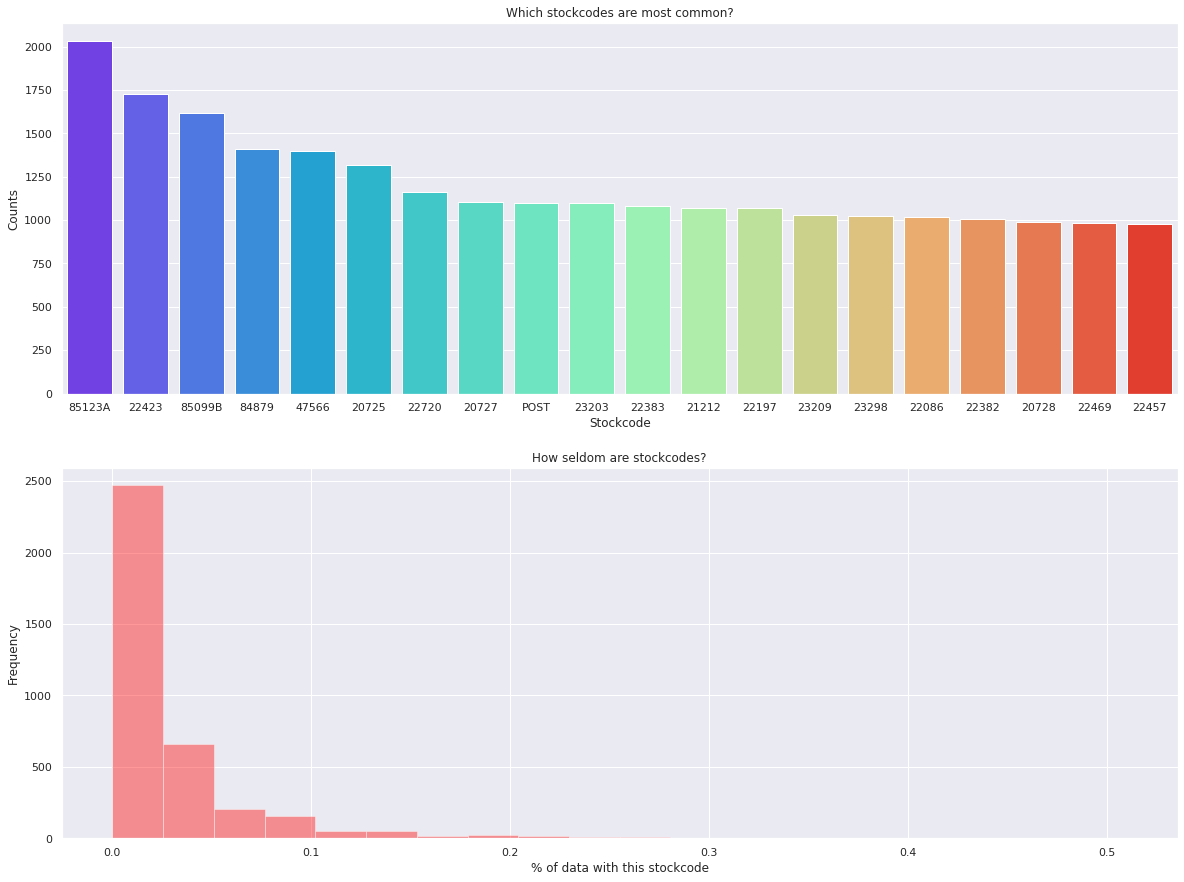

In [ ]:
stockcode_counts = data1.StockCode.value_counts().sort_values(ascending=False)
fig, ax = plt.subplots(2,1,figsize=(20,15))
sns.barplot(stockcode_counts.iloc[0:20].index,
            stockcode_counts.iloc[0:20].values,
            ax = ax[0], palette="rainbow")
ax[0].set_ylabel("Counts")
ax[0].set_xlabel("Stockcode")
ax[0].set_title("Which stockcodes are most common?");
sns.distplot(np.round(stockcode_counts/data1.shape[0]*100,2),
             kde=False,
             bins=20,
             ax=ax[1], color="red")

ax[1].set_title("How seldom are stockcodes?")
ax[1].set_xlabel("% of data with this stockcode")
ax[1].set_ylabel("Frequency")


Let's count the number of numeric chars in and the length of the stockcode:

In [ ]:
def count_numeric_chars(l):
    return sum(1 for c in l if c.isdigit())

data1["StockCodeLength"] = data1.StockCode.apply(lambda l: len(l))
data1["nNumericStockCode"] = data1.StockCode.apply(lambda l: count_numeric_chars(l))

In [ ]:
data1.loc[data1.nNumericStockCode < 5].lowercase_descriptions.value_counts()

postage                       1099
manual                         290
carriage                       133
dotcom postage                  16
bank charges                    12
pads to match all cushions       4
Name: lowercase_descriptions, dtype: int64

In [ ]:
data1 = data1.loc[(data1.nNumericStockCode == 5) & (data1.StockCodeLength==5)].copy()
data1.StockCode.nunique()

2785

In [ ]:
data1.StockCode

1         71053
5         22752
6         21730
7         22633
8         22632
          ...  
541904    22613
541905    22899
541906    23254
541907    23255
541908    22138
Name: StockCode, Length: 363119, dtype: object

In [ ]:
data1.Description.nunique()

2985

In [ ]:
data1.StockCode.nunique()

2785

In [ ]:
data1.CustomerID.nunique()

4315

In [ ]:
data1 = data1.drop(["nNumericStockCode", "StockCodeLength"], axis=1)

### Description:

Most common descriptions?

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <a list of 30 Text major ticklabel objects>)

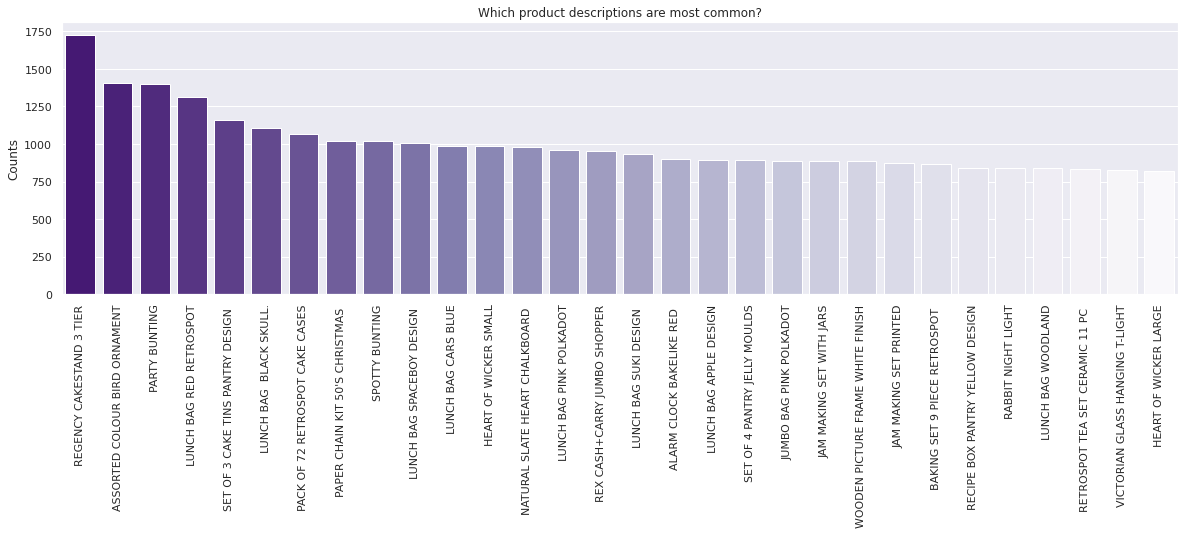

In [ ]:
description_counts = data1.Description.value_counts().sort_values(ascending=False).iloc[0:30]
plt.figure(figsize=(20,5))
sns.barplot(description_counts.index, description_counts.values, palette="Purples_r")
plt.ylabel("Counts")
plt.title("Which product descriptions are most common?");
plt.xticks(rotation=90)

In [ ]:
data1.loc[data1.CustomerID == '17841'].Description

Series([], Name: Description, dtype: object)

Some descriptions correspond to a similar product type.
We often have color information about the product as well. 

In [ ]:
def count_lower_chars(l):
    return sum(1 for c in l if c.islower())

In [ ]:
data1["DescriptionLength"] = data1.Description.apply(lambda l: len(l))
data1["LowCharsInDescription"] = data1.Description.apply(lambda l: count_lower_chars(l))

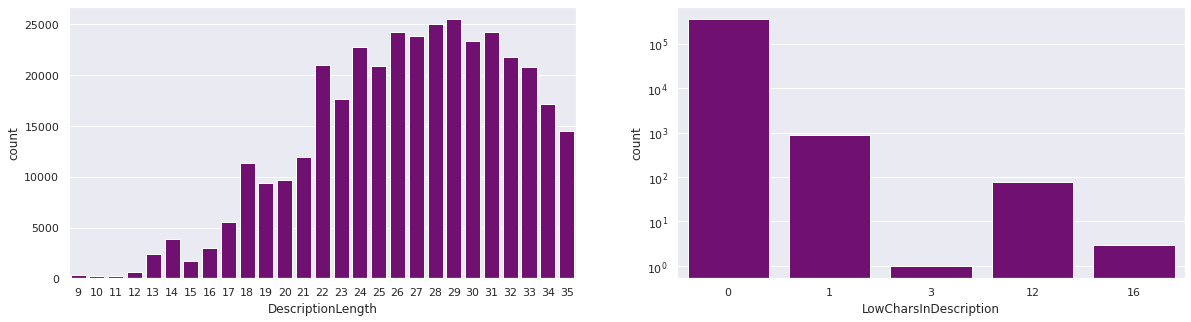

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.countplot(data1.DescriptionLength, ax=ax[0], color="Purple")
sns.countplot(data1.LowCharsInDescription, ax=ax[1], color="Purple")
ax[1].set_yscale("log")

In [ ]:
data1.groupby("StockCode").Description.nunique().sort_values(ascending=False).iloc[0:10]

StockCode
23196    4
23236    4
23535    3
23126    3
23203    3
23209    3
23413    3
23396    3
23231    3
23240    3
Name: Description, dtype: int64

We have stockcodes with multiple descriptions. Browsing through the cases we can see that stockcodes are sometimes named a bit differently due to missing or changed words or typing errors.

In [ ]:
data1.groupby(["StockCode","CustomerID"]).Quantity.sum()

StockCode  CustomerID
10002      12451         12
           12510         24
           12583         48
           12637         12
           12673          1
                         ..
90204      17976          1
90208      12748          1
           14911          6
           17360          2
           17596          1
Name: Quantity, Length: 243710, dtype: int64

### Customers:

In [ ]:
data1.CustomerID.nunique()

4315

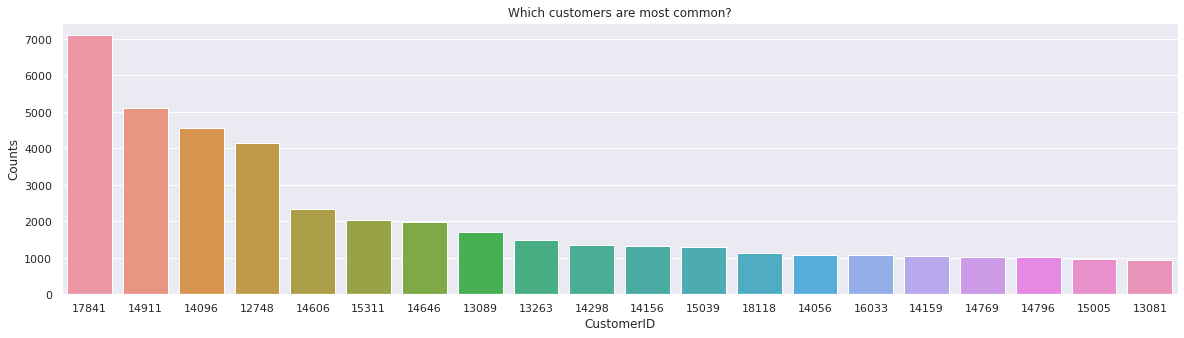

In [ ]:
customer_counts = data1.CustomerID.value_counts().sort_values(ascending=False).iloc[0:20] 
plt.figure(figsize=(20,5))
sns.barplot(customer_counts.index, customer_counts.values, order=customer_counts.index)
plt.ylabel("Counts")
plt.xlabel("CustomerID")
plt.title("Which customers are most common?");
#plt.xticks(rotation=90);

### UnitPrice & Quantity

In [ ]:
data1.UnitPrice.describe()

count    363119.000000
mean          2.886098
std           4.361971
min           0.000000
25%           1.250000
50%           1.700000
75%           3.750000
max         649.500000
Name: UnitPrice, dtype: float64

In [ ]:
data1.shape

(363119, 12)

Let's focus transactions with prices that fall into this range as we don't want to make predictions for very seldom products with high prices.

In [ ]:
data1 = data1.loc[(data1.UnitPrice > 0.1) & (data1.UnitPrice < 20)].copy()

In [ ]:
data1 = data1.loc[data1.Quantity < 55].copy()

In [ ]:
data1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales,lowercase_descriptions,DescriptionLength,LowCharsInDescription
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom,20.34,white metal lantern,19,0
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/2010 8:26,7.65,17850,United Kingdom,15.30,set 7 babushka nesting boxes,28,0
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,12/1/2010 8:26,4.25,17850,United Kingdom,25.50,glass star frosted t-light holder,33,0
7,536366,22633,HAND WARMER UNION JACK,6,12/1/2010 8:28,1.85,17850,United Kingdom,11.10,hand warmer union jack,22,0
8,536366,22632,HAND WARMER RED POLKA DOT,6,12/1/2010 8:28,1.85,17850,United Kingdom,11.10,hand warmer red polka dot,25,0


In [ ]:
data1.shape

(352019, 12)

### Preprocessing

In [ ]:
#!pip install texthero

In [ ]:
data1 = data1.drop(["DescriptionLength","LowCharsInDescription","lowercase_descriptions"],axis =1)

In [ ]:
#Data cleaning using Texthero:
from texthero import preprocessing
import texthero as hero

custom_pipeline = [preprocessing.fillna,
                   preprocessing.lowercase,
                   preprocessing.remove_whitespace,
                   preprocessing.remove_diacritics,
                   preprocessing.remove_brackets
                  ]
data1['Description'] = hero.clean(data1['Description'], custom_pipeline)
#df['Description'] = [n.replace('{','') for n in df['Description']]

data1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales
1,536365,71053,white metal lantern,6,12/1/2010 8:26,3.39,17850,United Kingdom,20.34
5,536365,22752,set 7 babushka nesting boxes,2,12/1/2010 8:26,7.65,17850,United Kingdom,15.30
6,536365,21730,glass star frosted t-light holder,6,12/1/2010 8:26,4.25,17850,United Kingdom,25.50
7,536366,22633,hand warmer union jack,6,12/1/2010 8:28,1.85,17850,United Kingdom,11.10
8,536366,22632,hand warmer red polka dot,6,12/1/2010 8:28,1.85,17850,United Kingdom,11.10


### Daily sales


Extract temporal features out of the InvoiceDate.

In [ ]:
data1["InvoiceDate"] = pd.to_datetime(data1.InvoiceDate, cache=True)

data1["Year"] = data1.InvoiceDate.dt.year
data1["Quarter"] = data1.InvoiceDate.dt.quarter
data1["Month"] = data1.InvoiceDate.dt.month
data1["Week"] = data1.InvoiceDate.dt.week
data1["Weekday"] = data1.InvoiceDate.dt.weekday
data1["Day"] = data1.InvoiceDate.dt.day
data1["Dayofyear"] = data1.InvoiceDate.dt.dayofyear
data1["Date"] = pd.to_datetime(data1[['Year', 'Month', 'Day']])


In [ ]:
data1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales,Year,Quarter,Month,Week,Weekday,Day,Dayofyear,Date
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010,4,12,48,2,1,335,2010-12-01
5,536365,22752,set 7 babushka nesting boxes,2,2010-12-01 08:26:00,7.65,17850,United Kingdom,15.30,2010,4,12,48,2,1,335,2010-12-01
6,536365,21730,glass star frosted t-light holder,6,2010-12-01 08:26:00,4.25,17850,United Kingdom,25.50,2010,4,12,48,2,1,335,2010-12-01
7,536366,22633,hand warmer union jack,6,2010-12-01 08:28:00,1.85,17850,United Kingdom,11.10,2010,4,12,48,2,1,335,2010-12-01
8,536366,22632,hand warmer red polka dot,6,2010-12-01 08:28:00,1.85,17850,United Kingdom,11.10,2010,4,12,48,2,1,335,2010-12-01


In [ ]:
data1.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID              int64
Country                object
Sales                 float64
Year                    int64
Quarter                 int64
Month                   int64
Week                    int64
Weekday                 int64
Day                     int64
Dayofyear               int64
Date           datetime64[ns]
dtype: object

In [ ]:
pd.unique(data1.Weekday)
#0 = Mon
#1 = Tue
#2 = Wed
#3 = Thu
#4 = Fri
#6 = Sun
#There is no Saturday

array([2, 3, 4, 6, 0, 1])

In [ ]:
data1["is_weekend"] = data1["Weekday"].isin([5, 6]).astype(np.int8)

In [ ]:
data1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales,Year,Quarter,Month,Week,Weekday,Day,Dayofyear,Date,is_weekend
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010,4,12,48,2,1,335,2010-12-01,0
5,536365,22752,set 7 babushka nesting boxes,2,2010-12-01 08:26:00,7.65,17850,United Kingdom,15.30,2010,4,12,48,2,1,335,2010-12-01,0
6,536365,21730,glass star frosted t-light holder,6,2010-12-01 08:26:00,4.25,17850,United Kingdom,25.50,2010,4,12,48,2,1,335,2010-12-01,0
7,536366,22633,hand warmer union jack,6,2010-12-01 08:28:00,1.85,17850,United Kingdom,11.10,2010,4,12,48,2,1,335,2010-12-01,0
8,536366,22632,hand warmer red polka dot,6,2010-12-01 08:28:00,1.85,17850,United Kingdom,11.10,2010,4,12,48,2,1,335,2010-12-01,0


In [ ]:
(data1.loc[data1.Weekday==6]).nunique()

InvoiceNo      2119
StockCode      2566
Description    2636
Quantity         47
InvoiceDate    1980
UnitPrice       108
CustomerID     1203
Country          19
Sales           855
Year              2
Quarter           4
Month            12
Week             49
Weekday           1
Day              31
Dayofyear        50
Date             50
is_weekend        1
dtype: int64

In [ ]:
(data1.loc[data1.Weekday==6]).shape

(56376, 18)

In [ ]:
data1.loc[data1.Weekday==6].Quantity.sum()
#11.40 % on Sun

335005

In [ ]:
data1.loc[data1.Weekday==6].Quantity.sum()

335005

### New Products:

In [ ]:
NPI = pd.DataFrame(data1.groupby(['StockCode']).agg({'Date': 'first','Year': 'first', 'Month': 'first','Week': 'first',"Day": 'first', 'Weekday': 'first',
                                                                'is_weekend' : 'first',    'Quantity': 'sum', 'UnitPrice': 'mean','Sales':'sum','Description':"first"}))
NPI = NPI.reset_index()
NPI

,StockCode,Date,Year,Month,Week,Day,Weekday,is_weekend,Quantity,UnitPrice,Sales,Description
0,10002,2010-12-01,2010,12,48,1,2,0,461,0.850000,391.85,inflatable political globe
1,10080,2011-02-27,2011,2,8,27,6,1,291,0.411905,114.41,groovy cactus inflatable
2,10120,2010-12-03,2010,12,48,3,4,0,193,0.210000,40.53,doggy rubber
3,10125,2010-12-01,2010,12,48,1,2,0,756,0.784407,556.60,mini funky design tapes
4,10133,2010-12-01,2010,12,48,1,2,0,1814,0.529322,874.11,colouring pencils brown tube
...,...,...,...,...,...,...,...,...,...,...,...,...
2747,90191,2011-02-20,2011,2,7,20,6,1,22,8.550000,113.90,silver lariat 40cm
2748,90192,2011-02-14,2011,2,7,14,0,0,23,4.950000,113.85,jade drop earrings w filigree
2749,90194,2010-12-16,2010,12,50,16,3,0,12,4.250000,51.00,silver lariat black stone earrings
2750,90204,2010-12-02,2010,12,48,2,3,0,17,3.350000,56.95,pair of enamel butterfly hairclip


In [ ]:
new_products = NPI.StockCode[(NPI.Date >= '2011-09-01')]
new_products = set(new_products)
print(len(new_products))
print(new_products)

233
{'22125', '23509', '23464', '23575', '23630', '23493', '23564', '23512', '23378', '23441', '23478', '23502', '23581', '23473', '23517', '23456', '23415', '23430', '23400', '23534', '23304', '23695', '23506', '23468', '23499', '23580', '23692', '23516', '23420', '23429', '23479', '23505', '23522', '84550', '23366', '23380', '23424', '23064', '23407', '23369', '90074', '23446', '23500', '23381', '23531', '23511', '23490', '23466', '23435', '23661', '23406', '23115', '23371', '23426', '23058', '23453', '23533', '23543', '23566', '47016', '23382', '23457', '23576', '23542', '23539', '23561', '23422', '23440', '23487', '23489', '23537', '23428', '23541', '23535', '23416', '23460', '23540', '23395', '23578', '23569', '23403', '23598', '23518', '23477', '23567', '23365', '23544', '23113', '23388', '23504', '23117', '23442', '23483', '23558', '23497', '23390', '20935', '23525', '23551', '23562', '23496', '90069', '23503', '23394', '23398', '23660', '23528', '23579', '23399', '23409', '2311

In [ ]:
#new_products are after date '2011-09-01':
data1[(data1.StockCode.isin(new_products)) & (data1.Date <'2011-09-01')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales,Year,Quarter,Month,Week,Weekday,Day,Dayofyear,Date,is_weekend


In [ ]:
new_data = NPI[NPI.StockCode.isin(new_products)]
print(new_data.shape)
new_data.head()

(233, 12)


,StockCode,Date,Year,Month,Week,Day,Weekday,is_weekend,Quantity,UnitPrice,Sales,Description
66,20678,2011-09-23,2011,9,38,23,4,0,4,1.650000,6.60,large black diamante hairslide
191,20935,2011-09-23,2011,9,38,23,4,0,6,2.950000,17.70,round cactus candle
389,21277,2011-09-29,2011,9,39,29,3,0,4,15.475000,68.85,french style embossed heart cabinet
941,22125,2011-11-23,2011,11,47,23,2,0,4,5.950000,23.80,union jack hot water bottle
1800,23058,2011-09-14,2011,9,37,14,2,0,486,1.112955,421.02,christmas hanging snowflake


In [ ]:
val_products = NPI.StockCode[(~(NPI.StockCode.isin(new_products))) & (NPI.Date >= '2011-08-01')]
val_products = set(val_products)
print(len(val_products))
print(val_products)

38
{'23353', '23189', '23350', '23354', '23324', '23437', '23433', '23332', '23327', '23360', '23445', '23436', '23329', '23325', '23374', '23333', '23439', '23352', '23356', '23359', '23431', '23432', '23331', '23349', '23351', '23358', '23438', '23326', '23328', '23355', '23357', '23348', '23334', '23375', '23330', '23373', '35650', '22340'}


In [ ]:
data1[data1.StockCode.isin(val_products) & (data1.Date < '2011-08-01')]
#data1[data1.StockCode.isin(new_products)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales,Year,Quarter,Month,Week,Weekday,Day,Dayofyear,Date,is_weekend


#### Daily Data:

In [ ]:
daily_data = pd.DataFrame(data1.groupby(['Date','StockCode']).agg({'Year': 'first', 'Month': 'first','Week': 'first',"Day": 'first', 'Weekday': 'first',
                                                                'is_weekend' : 'first',    'Quantity': 'sum', 'UnitPrice': 'mean','Sales':'sum','Description':"first"}))

In [ ]:
daily_data = daily_data.reset_index()
daily_data.head()

,Date,StockCode,Year,Month,Week,Day,Weekday,is_weekend,Quantity,UnitPrice,Sales,Description
0,2010-12-01,10002,2010,12,48,1,2,0,60,0.85,51.00,inflatable political globe
1,2010-12-01,10125,2010,12,48,1,2,0,2,0.85,1.70,mini funky design tapes
2,2010-12-01,10133,2010,12,48,1,2,0,5,0.85,4.25,colouring pencils brown tube
3,2010-12-01,16014,2010,12,48,1,2,0,10,0.42,4.20,small chinese style scissor
4,2010-12-01,16016,2010,12,48,1,2,0,10,0.85,8.50,large chinese style scissor


In [ ]:
daily_data.loc[:, ["Quantity", "Sales"]].describe()

,Quantity,Sales
count,196191.000000,196191.000000
mean,14.968852,28.187982
std,18.811419,43.918628
min,1.000000,0.120000
25%,3.000000,6.950000
50%,9.000000,15.300000
75%,20.000000,30.710000
max,411.000000,1266.300000


In [ ]:
low_quantity = daily_data.Quantity.quantile(0.01)
high_quantity = daily_data.Quantity.quantile(0.99)
print((low_quantity, high_quantity))

(1.0, 89.0)


In [ ]:
low_Sales = daily_data.Sales.quantile(0.01)
high_Sales = daily_data.Sales.quantile(0.99)
print((low_Sales, high_Sales))

(0.78, 204.0)


In [ ]:
samples = daily_data.shape[0]

In [ ]:
#Remove these just from the plot not from the data

daily_data = daily_data.loc[
    (daily_data.Quantity >= low_quantity) & (daily_data.Quantity <= high_quantity)]
daily_data = daily_data.loc[
    (daily_data.Sales >= low_Sales) & (daily_data.Sales <= high_Sales)]

In [ ]:
#How much entries have we lost?
samples - daily_data.shape[0]

5243

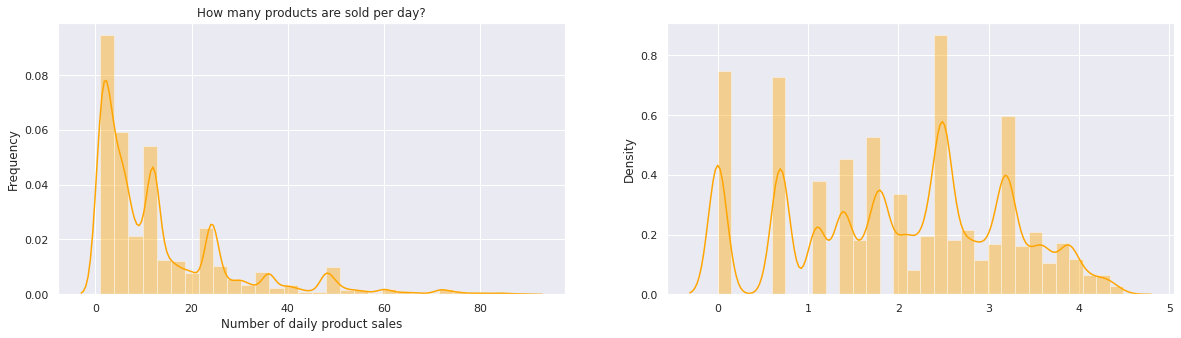

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.distplot(daily_data.Quantity.values, kde=True, ax=ax[0], color="Orange", bins=30);
sns.distplot(np.log(daily_data.Quantity.values), kde=True, ax=ax[1], color="Orange", bins=30);
ax[0].set_xlabel("Number of daily product sales");
ax[0].set_ylabel("Frequency");
ax[0].set_title("How many products are sold per day?");

#### New product split:

In [ ]:
print(pd.DataFrame(daily_data.loc[daily_data.StockCode.isin(new_products)].groupby("StockCode")).shape)
New_data1 = pd.DataFrame(daily_data.loc[daily_data.StockCode.isin(new_products)])

New_data1

(232, 2)


,Date,StockCode,Year,Month,Week,Day,Weekday,is_weekend,Quantity,UnitPrice,Sales,Description
120864,2011-09-01,23376,2011,9,35,1,3,0,48,0.390,18.72,pack of 12 vintage christmas tissue
120865,2011-09-01,23378,2011,9,35,1,3,0,48,0.390,18.72,pack of 12 50's christmas tissues
120878,2011-09-01,23551,2011,9,35,1,3,0,12,0.390,4.68,pack of 12 paisley park tissues
122173,2011-09-04,23377,2011,9,35,4,6,1,12,0.390,4.68,pack of 12 dolly girl tissues
122174,2011-09-04,23393,2011,9,35,4,6,1,10,3.750,37.50,home sweet home cushion cover
...,...,...,...,...,...,...,...,...,...,...,...,...
196160,2011-12-09,23570,2011,12,49,9,4,0,24,1.250,30.00,traditional pick up sticks game
196161,2011-12-09,23571,2011,12,49,9,4,0,12,1.650,19.80,traditional naughts & crosses
196162,2011-12-09,23581,2011,12,49,9,4,0,50,1.935,92.40,jumbo bag paisley park
196163,2011-12-09,23598,2011,12,49,9,4,0,6,2.950,17.70,paper bunting vintage party


In [ ]:
# it doesn't contain val_products
old_products = NPI.StockCode[(~NPI.StockCode.isin(new_products)) & (~NPI.StockCode.isin(val_products))]
old_products = set(old_products)
print(len(old_products)) 

2481


In [ ]:
old_data = data1[data1.StockCode.isin(old_products) ]#& (data1.Date<'2011-08-01')
print(old_data.shape)
old_data

(330913, 18)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales,Year,Quarter,Month,Week,Weekday,Day,Dayofyear,Date,is_weekend
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010,4,12,48,2,1,335,2010-12-01,0
5,536365,22752,set 7 babushka nesting boxes,2,2010-12-01 08:26:00,7.65,17850,United Kingdom,15.30,2010,4,12,48,2,1,335,2010-12-01,0
6,536365,21730,glass star frosted t-light holder,6,2010-12-01 08:26:00,4.25,17850,United Kingdom,25.50,2010,4,12,48,2,1,335,2010-12-01,0
7,536366,22633,hand warmer union jack,6,2010-12-01 08:28:00,1.85,17850,United Kingdom,11.10,2010,4,12,48,2,1,335,2010-12-01,0
8,536366,22632,hand warmer red polka dot,6,2010-12-01 08:28:00,1.85,17850,United Kingdom,11.10,2010,4,12,48,2,1,335,2010-12-01,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,pack of 20 spaceboy napkins,12,2011-12-09 12:50:00,0.85,12680,France,10.20,2011,4,12,49,4,9,343,2011-12-09,0
541905,581587,22899,children's apron dolly girl,6,2011-12-09 12:50:00,2.10,12680,France,12.60,2011,4,12,49,4,9,343,2011-12-09,0
541906,581587,23254,childrens cutlery dolly girl,4,2011-12-09 12:50:00,4.15,12680,France,16.60,2011,4,12,49,4,9,343,2011-12-09,0
541907,581587,23255,childrens cutlery circus parade,4,2011-12-09 12:50:00,4.15,12680,France,16.60,2011,4,12,49,4,9,343,2011-12-09,0


In [ ]:
print(pd.DataFrame(daily_data.loc[daily_data.StockCode.isin(old_products)].groupby("StockCode")).shape)
Old_data1 = pd.DataFrame(daily_data.loc[daily_data.StockCode.isin(old_products)]) # & (daily_data.Date < '2011-08-01') 

Old_data1

(2479, 2)


,Date,StockCode,Year,Month,Week,Day,Weekday,is_weekend,Quantity,UnitPrice,Sales,Description
0,2010-12-01,10002,2010,12,48,1,2,0,60,0.85,51.00,inflatable political globe
1,2010-12-01,10125,2010,12,48,1,2,0,2,0.85,1.70,mini funky design tapes
2,2010-12-01,10133,2010,12,48,1,2,0,5,0.85,4.25,colouring pencils brown tube
3,2010-12-01,16014,2010,12,48,1,2,0,10,0.42,4.20,small chinese style scissor
4,2010-12-01,16016,2010,12,48,1,2,0,10,0.85,8.50,large chinese style scissor
...,...,...,...,...,...,...,...,...,...,...,...,...
196186,2011-12-09,85038,2011,12,49,9,4,0,84,1.85,155.40,6 chocolate love heart t-lights
196187,2011-12-09,85053,2011,12,49,9,4,0,2,2.10,4.20,french enamel candleholder
196188,2011-12-09,85066,2011,12,49,9,4,0,4,12.75,51.00,cream sweetheart mini chest
196189,2011-12-09,85152,2011,12,49,9,4,0,48,1.85,88.80,hand over the chocolate sign


In [ ]:
val_data = data1[data1.StockCode.isin(val_products)]# & (data1.Date < '2011-09-01')
print(val_data.shape)
val_data

(6187, 18)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales,Year,Quarter,Month,Week,Weekday,Day,Dayofyear,Date,is_weekend
285702,561917,35650,vintage bead pink jewel stand,1,2011-08-01 11:57:00,4.95,16904,United Kingdom,4.95,2011,3,8,31,0,1,213,2011-08-01,0
287087,562049,23360,set 8 candles vintage doiley,12,2011-08-02 11:33:00,1.95,14133,United Kingdom,23.40,2011,3,8,31,1,2,214,2011-08-02,0
287135,562085,23359,set of 12 t-lights vintage doiley,12,2011-08-02 12:27:00,1.95,15228,United Kingdom,23.40,2011,3,8,31,1,2,214,2011-08-02,0
287136,562085,23360,set 8 candles vintage doiley,12,2011-08-02 12:27:00,1.95,15228,United Kingdom,23.40,2011,3,8,31,1,2,214,2011-08-02,0
287286,562101,23373,vintage christmas paper gift bag,10,2011-08-02 14:04:00,0.82,13850,United Kingdom,8.20,2011,3,8,31,1,2,214,2011-08-02,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541813,581579,23353,6 gift tags vintage christmas,12,2011-12-09 12:19:00,0.83,17581,United Kingdom,9.96,2011,4,12,49,4,9,343,2011-12-09,0
541814,581579,23350,roll wrap vintage spot,25,2011-12-09 12:19:00,1.25,17581,United Kingdom,31.25,2011,4,12,49,4,9,343,2011-12-09,0
541836,581580,23334,ivory wicker heart small,4,2011-12-09 12:20:00,0.63,12748,United Kingdom,2.52,2011,4,12,49,4,9,343,2011-12-09,0
541878,581585,23356,love hot water bottle,3,2011-12-09 12:31:00,5.95,15804,United Kingdom,17.85,2011,4,12,49,4,9,343,2011-12-09,0


In [ ]:
print(pd.DataFrame(daily_data.loc[daily_data.StockCode.isin(val_products)].groupby("StockCode")).shape)
Val_data1 = pd.DataFrame(daily_data.loc[daily_data.StockCode.isin(val_products)])# & (daily_data.Date < '2011-09-01') 

Val_data1

(38, 2)


,Date,StockCode,Year,Month,Week,Day,Weekday,is_weekend,Quantity,UnitPrice,Sales,Description
105967,2011-08-01,35650,2011,8,31,1,0,0,1,4.95,4.95,vintage bead pink jewel stand
106561,2011-08-02,23353,2011,8,31,2,1,0,12,0.83,9.96,6 gift tags vintage christmas
106562,2011-08-02,23354,2011,8,31,2,1,0,12,0.83,9.96,6 gift tags 50's christmas
106563,2011-08-02,23359,2011,8,31,2,1,0,12,1.95,23.40,set of 12 t-lights vintage doiley
106564,2011-08-02,23360,2011,8,31,2,1,0,24,1.95,46.80,set 8 candles vintage doiley
...,...,...,...,...,...,...,...,...,...,...,...,...
196124,2011-12-09,23358,2011,12,49,9,4,0,18,1.25,22.50,hot stuff hot water bottle
196137,2011-12-09,23437,2011,12,49,9,4,0,12,1.25,15.00,50's christmas gift bag large
196138,2011-12-09,23438,2011,12,49,9,4,0,12,1.25,15.00,red spot gift bag large
196139,2011-12-09,23439,2011,12,49,9,4,0,36,2.10,75.60,hand warmer red love heart


In [ ]:
len(old_products)+len(val_products)+len(new_products)==len(set(data1.StockCode))

True

In [ ]:
(Old_data1.shape[0]) + (New_data1.shape[0]) + (Val_data1.shape[0]) == daily_data.shape[0]

True

In [ ]:
#separate old, validation and new products:
old_desc = set(list(Old_data1['Description']))
old_desc = list(old_desc)
print(len(old_desc))

2596


In [ ]:
val_desc = set(list(Val_data1['Description']))
val_desc = list(val_desc)
print(len(val_desc))

45


In [ ]:
new_desc = set(list(New_data1['Description']))
new_desc = list(new_desc)
print(len(new_desc))

273


### Vectorize Description:

In [ ]:
#!pip install sentence_transformers

In [ ]:
#ROBERTA:
from sentence_transformers import SentenceTransformer, util
roberta_model = SentenceTransformer('stsb-roberta-base-v2')
roberta_model.max_seq_length = 200


In [ ]:
#Encode descriptions of the old products:
roberta_old = roberta_model.encode(old_desc)

In [ ]:
roberta_old.shape

(2596, 768)

#### UMAP:

In [ ]:
#!pip install umap
#!pip install umap-learn[plot]

In [ ]:
import umap
import umap.plot
UMAP_roberta = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(roberta_old)

In [ ]:
UMAP_roberta

array([[-0.3405536,  4.4426966],
       [ 1.5698364,  4.218132 ],
       [ 1.1723512,  3.5062952],
       ...,
       [-1.8641111,  4.283966 ],
       [ 3.377056 ,  4.410296 ],
       [ 3.658826 ,  4.8481927]], dtype=float32)

#### KMeans:

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 10, random_state = 0).fit(UMAP_roberta)
kmeans.labels_

array([2, 2, 1, ..., 3, 4, 4], dtype=int32)

In [ ]:
y_kmeans = kmeans.predict(UMAP_roberta)
y_kmeans

array([2, 2, 1, ..., 3, 4, 4], dtype=int32)

Text(0.5, 1.0, 'KMeans k=10, on UMAP for old products + Roberta')

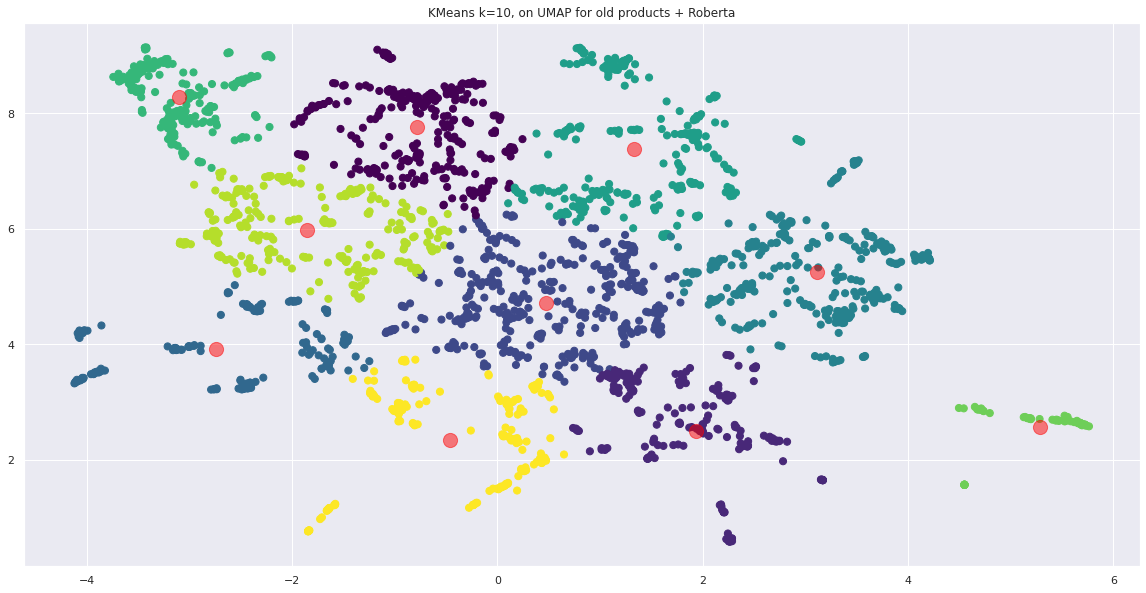

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.scatter(UMAP_roberta[:,0], UMAP_roberta[:,1] , c = y_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:,0],centers[:,1], c='red', s=200, alpha=0.5)
plt.title("KMeans k=10, on UMAP for old products + Roberta")


In [ ]:
set(kmeans.labels_)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [ ]:
#scipy cdist ?????????????????????????????????

In [ ]:
#word_cloud

In [ ]:
desc_df = pd.DataFrame(old_desc, columns=["Desc"])
desc_df['Topic'] = kmeans.labels_
desc_per_topic = desc_df.groupby(['Topic'], as_index = False).agg({'Desc': ' '.join})

In [ ]:
desc_df

,Desc,Topic
0,"birthday card, retro spot",2
1,tropical luggage tag,2
2,vintage union jack shopping bag,1
3,polkadot coffee cup & saucer pink,4
4,banquet birthday card,2
...,...,...
2591,doormat keep calm and come in,4
2592,dairy maid pudding bowl,4
2593,black record cover frame,3
2594,vintage billboard drink me mug,4


In [ ]:
data_df = pd.DataFrame(Old_data1, columns=['Date','StockCode','Year','Month','Week','Day','Weekday','is_weekend','Quantity','Description'])

In [ ]:
topics = {}
for i in list(set(kmeans.labels_)):
    topics["D{0}".format(i)] = list(desc_df["Desc"][desc_df['Topic']== i])

In [ ]:
topics.keys()

dict_keys(['D0', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9'])

In [ ]:
#data_df['Topic'] = 'Null'
data_df

,Date,StockCode,Year,Month,Week,Day,Weekday,is_weekend,Quantity,Description,Topic
0,2010-12-01,10002,2010,12,48,1,2,0,60,inflatable political globe,Null
1,2010-12-01,10125,2010,12,48,1,2,0,2,mini funky design tapes,Null
2,2010-12-01,10133,2010,12,48,1,2,0,5,colouring pencils brown tube,Null
3,2010-12-01,16014,2010,12,48,1,2,0,10,small chinese style scissor,Null
4,2010-12-01,16016,2010,12,48,1,2,0,10,large chinese style scissor,Null
...,...,...,...,...,...,...,...,...,...,...,...
196186,2011-12-09,85038,2011,12,49,9,4,0,84,6 chocolate love heart t-lights,Null
196187,2011-12-09,85053,2011,12,49,9,4,0,2,french enamel candleholder,Null
196188,2011-12-09,85066,2011,12,49,9,4,0,4,cream sweetheart mini chest,Null
196189,2011-12-09,85152,2011,12,49,9,4,0,48,hand over the chocolate sign,Null


In [ ]:
for index, row in data_df.iterrows():
    for i in range(len(topics.keys())):
        if (row['Description'] in list(topics.values())[i]):
            data_df['Topic'][index] = i

In [ ]:
# change stockcode and Topic type to category:
data_df["StockCode"] = data_df["StockCode"].astype('category')
data_df["Topic"] = data_df["Topic"].astype('category')

In [ ]:
data_df.dtypes

Date           datetime64[ns]
StockCode            category
Year                    int64
Month                   int64
Week                    int64
Day                     int64
Weekday                 int64
is_weekend               int8
Quantity                int64
Description            object
Topic                category
dtype: object

#### Create df for each Topic:

In [ ]:
topics.keys()

dict_keys(['D0', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9'])

In [ ]:
topics_df = {}
for i in range(len(topics.keys())):
    topics_df["data_df_D{0}".format(i)] = data_df[data_df["Topic"]== i]

In [ ]:
topics_df.keys()

dict_keys(['data_df_D0', 'data_df_D1', 'data_df_D2', 'data_df_D3', 'data_df_D4', 'data_df_D5', 'data_df_D6', 'data_df_D7', 'data_df_D8', 'data_df_D9'])

#### Run LGBM on all Old product, without clustering and descriptions: 

In [ ]:
Old_data1["StockCode"] = Old_data1["StockCode"].astype('category')

In [ ]:
x_tr_old = Old_data1[Old_data1['Date'] <= '2011-11-01'].drop(['Date','Description','Quantity','Sales','UnitPrice'],axis = 1)

In [ ]:
y_tr_old = Old_data1[Old_data1['Date'] <= '2011-11-01']['Quantity']

In [ ]:
x_val_old = Old_data1[(Old_data1['Date'] > '2011-11-01') & (Old_data1['Date'] <= '2011-12-01')].drop(['Date','Description','Quantity','Sales','UnitPrice'],axis = 1)

In [ ]:
y_val_old = Old_data1[(Old_data1['Date'] > '2011-11-01') & (Old_data1['Date'] <= '2011-12-01')]['Quantity']

In [ ]:
x_te_old = Old_data1[(Old_data1['Date'] > '2011-12-01')].drop(['Date','Description','Quantity','Sales','UnitPrice'],axis = 1)

In [ ]:
y_te_old = Old_data1[(Old_data1['Date'] > '2011-12-01')]['Quantity']

In [ ]:
#!pip install optuna

In [ ]:
import optuna
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
#optimization:
def objective(trial):



        param = {
            'metric': 'rmse', 
            'random_state': 48,
            'n_estimators': trial.suggest_int('n_estimators',  200, 300, 500),
            'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
            'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
            'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
            'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
            'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
            # 'max_depth': trial.suggest_categorical('max_depth', [10,20,100]),
            'num_leaves' : trial.suggest_int('num_leaves', 30, 200, 1000),  
            'min_child_samples': trial.suggest_int('min_child_samples', 10, 300, 1000),
            'cat_smooth' : trial.suggest_int('min_data_per_groups', 1, 100)
        }


        model_old_df = LGBMRegressor(**param)
        model_old_df.fit(x_tr_old, y_tr_old, eval_set=[(x_val_old ,y_val_old)],early_stopping_rounds=100,verbose=False)
        pred_old_df = model_old_df.predict(x_te_old)
        rmse_old_df = mean_squared_error(y_te_old, model_old_df.predict(x_te_old), squared=False)

        return rmse_old_df    
    
    
    
    

In [ ]:
# the objective of our fuction is to minimize the RMSE that's why direction='minimize':
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
params=study.best_params   


model_old_df= LGBMRegressor(**params)
model_old_df.fit(x_tr_old,y_tr_old,eval_set=[(x_val_old, y_val_old)],early_stopping_rounds=100,verbose=False)
pred_old_df = model_old_df.predict(x_te_old)
rmse_old_df = mean_squared_error(y_te_old, model_old_df.predict(x_te_old), squared=False)
rmseVal_old_df = mean_squared_error(y_val_old, model_old_df.predict(x_val_old), squared=False)


[I 2022-03-22 02:20:55,648] A new study created in memory with name: no-name-4a15bb70-d87d-4cf2-9f6f-92fa2c5b6e94
[I 2022-03-22 02:21:03,024] Trial 0 finished with value: 14.971093864829795 and parameters: {'n_estimators': 200, 'reg_alpha': 0.031197057411964074, 'reg_lambda': 8.55691946372133, 'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.014, 'num_leaves': 30, 'min_child_samples': 10, 'min_data_per_groups': 62}. Best is trial 0 with value: 14.971093864829795.
[I 2022-03-22 02:21:07,542] Trial 1 finished with value: 14.791822452876984 and parameters: {'n_estimators': 200, 'reg_alpha': 8.93081901605747, 'reg_lambda': 1.3580690110184397, 'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.02, 'num_leaves': 30, 'min_child_samples': 10, 'min_data_per_groups': 36}. Best is trial 1 with value: 14.791822452876984.
[I 2022-03-22 02:21:10,032] Trial 2 finished with value: 15.124508580258544 and parameters: {'n_estimators': 200, 'reg_alpha': 0.08324517699886405, 'reg_la

Number of finished trials: 50
Best trial: {'n_estimators': 200, 'reg_alpha': 0.02829509494171487, 'reg_lambda': 0.1519763732532614, 'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.02, 'num_leaves': 30, 'min_child_samples': 10, 'min_data_per_groups': 10}


In [ ]:
import math

math.sqrt(rmse_old_df)

3.837599644732059

#### Train-test  split each df, for all topics:

#### Train set:

In [ ]:
x_tr_df = {}
for i in range(len(topics.keys())):
    x_tr_df["x_tr_{0}".format(i)] = data_df[(data_df["Topic"] == i) &  (data_df['Date'] <= '2011-11-01')].drop(['Date','Description','Topic','Quantity'],axis = 1)

In [ ]:
x_tr_df.keys()

dict_keys(['x_tr_0', 'x_tr_1', 'x_tr_2', 'x_tr_3', 'x_tr_4', 'x_tr_5', 'x_tr_6', 'x_tr_7', 'x_tr_8', 'x_tr_9'])

In [ ]:
y_tr_df = {}
for i in range(len(topics.keys())):
    y_tr_df["y_tr_{0}".format(i)] = data_df[(data_df["Topic"] == i) &  (data_df['Date'] <= '2011-11-01')]['Quantity']

#### Validation set:

In [ ]:
x_val_df = {}
for i in range(len(topics.keys())):
    x_val_df["x_val_{0}".format(i)]=data_df[(data_df["Topic"]==i)&(data_df['Date']>'2011-11-01')&
                                                (data_df['Date']<='2011-12-01')].drop(['Date','Description','Topic','Quantity'],axis = 1)

In [ ]:
x_val_df.keys()

dict_keys(['x_val_0', 'x_val_1', 'x_val_2', 'x_val_3', 'x_val_4', 'x_val_5', 'x_val_6', 'x_val_7', 'x_val_8', 'x_val_9'])

In [ ]:
y_val_df = {}
for i in range(len(topics.keys())):
    y_val_df["y_val_{0}".format(i)]=data_df[(data_df["Topic"]==i)&
                                                (data_df['Date']>'2011-11-01')&(data_df['Date']<='2011-12-01')]['Quantity']

#### Test set:

In [ ]:
x_te_df = {}
for i in range(len(topics.keys())):
    x_te_df["x_te_{0}".format(i)] = data_df[(data_df["Topic"] == i) & 
                                                (data_df['Date']>'2011-12-01')].drop(['Date','Description','Topic','Quantity'],axis = 1)

In [ ]:
y_te_df = {}
for i in range(len(topics.keys())):
    y_te_df["y_te_{0}".format(i)] = data_df[(data_df["Topic"] == i) & (data_df['Date']>'2011-12-01')]['Quantity']

In [ ]:
Shape_old = {}
for i in topics_df.keys():
    Shape_old.update({i: topics_df[i].shape[0]})
     
print(Shape_old)  

{'data_df_D0': 18954, 'data_df_D1': 24121, 'data_df_D2': 26599, 'data_df_D3': 13585, 'data_df_D4': 27153, 'data_df_D5': 22782, 'data_df_D6': 10848, 'data_df_D7': 8601, 'data_df_D8': 14054, 'data_df_D9': 15194}


In [ ]:
#number of records in each cluster:
records_old = pd.DataFrame.from_dict(Shape_old , orient='index' , columns=['records'])
records_old = records_old.reset_index()

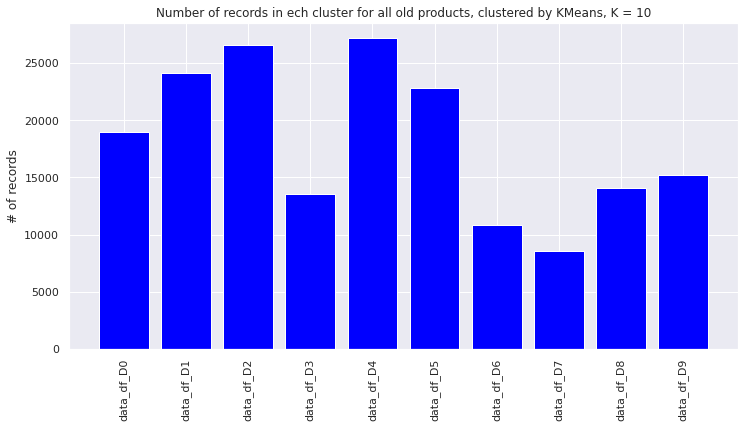

In [ ]:
plt.figure(figsize=(12,6)) 
plt.bar(records_old['index'], records_old['records'] ,color="blue")
#records.plot(x='index', y='records', kind="bar")

plt.ylabel("# of records")
plt.title("Number of records in ech cluster for all old products, clustered by KMeans, K = 10");
plt.xticks(rotation=90)
plt.show()

#### LGBM Model on all old products, for each cluster:

In [ ]:
import optuna
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
model_df = {}
pred_df = {}
rmse_df = {}
rmseVal_df = {}
global_y_df = []
global_pred_df = []

for i in range(len(topics_df.keys())):
    #optimization:
    params = {}
    def objective(trial):


        param = {
            
            'metric': 'rmse', 
            'random_state': 48,
            'n_estimators': trial.suggest_int('n_estimators', 200, 300, 500),
            'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
            'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
            'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
            'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
            'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
             # 'max_depth': trial.suggest_categorical('max_depth', [10,20,100]),
            'num_leaves' : trial.suggest_int('num_leaves', 30, 200, 1000), # range(3, 1000) 
            'min_child_samples': trial.suggest_int('min_child_samples', 10, 300, 1000),
            'cat_smooth' : trial.suggest_int('min_data_per_groups', 1, 100)
        }


        model_df["model_{0}".format(i)] = LGBMRegressor(**param)
        model_df["model_{0}".format(i)].fit(x_tr_df['x_tr_{0}'.format(i)],y_tr_df['y_tr_{0}'.format(i)],
                                        eval_set=[(x_val_df['x_val_{0}'.format(i)],y_val_df['y_val_{0}'.format(i)])],early_stopping_rounds=100,verbose=False)
        pred_df["pred_{0}".format(i)] = model_df["model_{0}".format(i)].predict(x_te_df['x_te_{0}'.format(i)])
        rmse_df["rmse_{0}".format(i)] = mean_squared_error(y_te_df['y_te_{0}'.format(i)], model_df["model_{0}".format(i)].predict(x_te_df['x_te_{0}'.format(i)]), squared=False)

        return rmse_df["rmse_{0}".format(i)]
    
    
    
    # the objective of our fuction is to minimize the RMSE that's why direction='minimize':
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=50)
    print('Number of finished trials:', len(study.trials))
    print('Best trial:', study.best_trial.params)
    params=study.best_params   


    model_df["model_{0}".format(i)] = LGBMRegressor(**params)
    model_df["model_{0}".format(i)].fit(x_tr_df['x_tr_{0}'.format(i)],y_tr_df['y_tr_{0}'.format(i)],
                                        eval_set=[(x_val_df['x_val_{0}'.format(i)],y_val_df['y_val_{0}'.format(i)])],early_stopping_rounds=100,verbose=False)
    pred_df["pred_{0}".format(i)] = model_df["model_{0}".format(i)].predict(x_te_df['x_te_{0}'.format(i)])
    rmse_df["rmse_{0}".format(i)] = mean_squared_error(y_te_df['y_te_{0}'.format(i)], 
                                                       model_df["model_{0}".format(i)].predict(x_te_df['x_te_{0}'.format(i)]), squared=False)
    rmseVal_df["rmseVal_{0}".format(i)] = mean_squared_error(y_val_df['y_val_{0}'.format(i)], model_df["model_{0}".format(i)].predict(x_val_df['x_val_{0}'.format(i)]), squared=False)
    global_y_df.append(list(y_te_df['y_te_{0}'.format(i)]))
    global_pred_df.append(list(pred_df["pred_{0}".format(i)]))


[I 2022-03-22 02:28:45,060] A new study created in memory with name: no-name-5cb488a3-2074-4cc3-b75e-f84b0ea375a5
[I 2022-03-22 02:28:45,355] Trial 0 finished with value: 15.191497600442483 and parameters: {'n_estimators': 200, 'reg_alpha': 1.0374384950665712, 'reg_lambda': 6.0193211007322205, 'colsample_bytree': 0.3, 'subsample': 0.7, 'learning_rate': 0.017, 'num_leaves': 30, 'min_child_samples': 10, 'min_data_per_groups': 25}. Best is trial 0 with value: 15.191497600442483.
[I 2022-03-22 02:28:45,655] Trial 1 finished with value: 15.7439678486743 and parameters: {'n_estimators': 200, 'reg_alpha': 0.017472031985306703, 'reg_lambda': 0.0027272572282408705, 'colsample_bytree': 0.3, 'subsample': 0.6, 'learning_rate': 0.01, 'num_leaves': 30, 'min_child_samples': 10, 'min_data_per_groups': 49}. Best is trial 0 with value: 15.191497600442483.
[I 2022-03-22 02:28:46,049] Trial 2 finished with value: 16.398463225623054 and parameters: {'n_estimators': 200, 'reg_alpha': 0.5142117448247894, 're

Number of finished trials: 50
Best trial: {'n_estimators': 200, 'reg_alpha': 0.008128010312065375, 'reg_lambda': 0.030281265907713056, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.01, 'num_leaves': 30, 'min_child_samples': 10, 'min_data_per_groups': 9}


[I 2022-03-22 02:29:07,428] A new study created in memory with name: no-name-210c2c54-9866-4719-87ce-9e6a15176725
[I 2022-03-22 02:29:07,823] Trial 0 finished with value: 13.86312491535127 and parameters: {'n_estimators': 200, 'reg_alpha': 0.001107422561264587, 'reg_lambda': 9.697120305826347, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.017, 'num_leaves': 30, 'min_child_samples': 10, 'min_data_per_groups': 59}. Best is trial 0 with value: 13.86312491535127.
[I 2022-03-22 02:29:08,303] Trial 1 finished with value: 13.165445276210137 and parameters: {'n_estimators': 200, 'reg_alpha': 0.08426317232439742, 'reg_lambda': 0.0027859544012084608, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.017, 'num_leaves': 30, 'min_child_samples': 10, 'min_data_per_groups': 22}. Best is trial 1 with value: 13.165445276210137.
[I 2022-03-22 02:29:08,632] Trial 2 finished with value: 14.738313300957381 and parameters: {'n_estimators': 200, 'reg_alpha': 0.021091277544621097, 

Number of finished trials: 50
Best trial: {'n_estimators': 200, 'reg_alpha': 0.011502916518008489, 'reg_lambda': 1.1117826990975415, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.02, 'num_leaves': 30, 'min_child_samples': 10, 'min_data_per_groups': 4}


[I 2022-03-22 02:29:31,957] A new study created in memory with name: no-name-f95d08ab-7719-431f-a52e-ccaf6305e8e8
[I 2022-03-22 02:29:32,325] Trial 0 finished with value: 13.629090738967326 and parameters: {'n_estimators': 200, 'reg_alpha': 0.21598952596306378, 'reg_lambda': 0.12410191410739209, 'colsample_bytree': 0.3, 'subsample': 0.6, 'learning_rate': 0.017, 'num_leaves': 30, 'min_child_samples': 10, 'min_data_per_groups': 69}. Best is trial 0 with value: 13.629090738967326.
[I 2022-03-22 02:29:32,834] Trial 1 finished with value: 12.86401834144603 and parameters: {'n_estimators': 200, 'reg_alpha': 0.25369679680690477, 'reg_lambda': 5.447402069050755, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.017, 'num_leaves': 30, 'min_child_samples': 10, 'min_data_per_groups': 31}. Best is trial 1 with value: 12.86401834144603.
[I 2022-03-22 02:29:33,332] Trial 2 finished with value: 12.857114128329899 and parameters: {'n_estimators': 200, 'reg_alpha': 1.902414947403707, 'reg_l

Number of finished trials: 50
Best trial: {'n_estimators': 200, 'reg_alpha': 0.0014445156569552118, 'reg_lambda': 0.002131960615381816, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.017, 'num_leaves': 30, 'min_child_samples': 10, 'min_data_per_groups': 41}


[I 2022-03-22 02:29:58,338] A new study created in memory with name: no-name-e0d692bb-558f-46b8-88bb-eeaf9fd711ef
[I 2022-03-22 02:29:58,600] Trial 0 finished with value: 15.052995931260936 and parameters: {'n_estimators': 200, 'reg_alpha': 0.577211028867882, 'reg_lambda': 0.0157381003671987, 'colsample_bytree': 0.3, 'subsample': 0.7, 'learning_rate': 0.02, 'num_leaves': 30, 'min_child_samples': 10, 'min_data_per_groups': 70}. Best is trial 0 with value: 15.052995931260936.
[I 2022-03-22 02:29:58,844] Trial 1 finished with value: 15.225964187027223 and parameters: {'n_estimators': 200, 'reg_alpha': 0.0024430346593872915, 'reg_lambda': 0.0030174398177778253, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.006, 'num_leaves': 30, 'min_child_samples': 10, 'min_data_per_groups': 81}. Best is trial 0 with value: 15.052995931260936.
[I 2022-03-22 02:29:59,215] Trial 2 finished with value: 14.390760870246156 and parameters: {'n_estimators': 200, 'reg_alpha': 0.0022204614796171493

Number of finished trials: 50
Best trial: {'n_estimators': 200, 'reg_alpha': 0.35203930010334483, 'reg_lambda': 0.008652754003933859, 'colsample_bytree': 1.0, 'subsample': 0.4, 'learning_rate': 0.02, 'num_leaves': 30, 'min_child_samples': 10, 'min_data_per_groups': 63}


[I 2022-03-22 02:30:15,967] A new study created in memory with name: no-name-2f8f2c46-69ca-48f9-94a7-46151138b40a
[I 2022-03-22 02:30:16,335] Trial 0 finished with value: 12.581160701613266 and parameters: {'n_estimators': 200, 'reg_alpha': 0.001849293790341378, 'reg_lambda': 0.1452048148605496, 'colsample_bytree': 0.3, 'subsample': 0.6, 'learning_rate': 0.01, 'num_leaves': 30, 'min_child_samples': 10, 'min_data_per_groups': 93}. Best is trial 0 with value: 12.581160701613266.
[I 2022-03-22 02:30:16,879] Trial 1 finished with value: 11.76455345175448 and parameters: {'n_estimators': 200, 'reg_alpha': 0.02751488411550886, 'reg_lambda': 0.07627963660648139, 'colsample_bytree': 0.6, 'subsample': 0.4, 'learning_rate': 0.01, 'num_leaves': 30, 'min_child_samples': 10, 'min_data_per_groups': 49}. Best is trial 1 with value: 11.76455345175448.
[I 2022-03-22 02:30:17,252] Trial 2 finished with value: 12.034909443643576 and parameters: {'n_estimators': 200, 'reg_alpha': 0.02751188472781243, 'reg

Number of finished trials: 50
Best trial: {'n_estimators': 200, 'reg_alpha': 1.768970397870764, 'reg_lambda': 9.998007861595113, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.02, 'num_leaves': 30, 'min_child_samples': 10, 'min_data_per_groups': 1}


[I 2022-03-22 02:30:41,545] A new study created in memory with name: no-name-5c2126b8-e683-4da2-9863-f83d7d95ef76
[I 2022-03-22 02:30:41,918] Trial 0 finished with value: 19.084937272531263 and parameters: {'n_estimators': 200, 'reg_alpha': 2.693788707032665, 'reg_lambda': 5.591833379795682, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.017, 'num_leaves': 30, 'min_child_samples': 10, 'min_data_per_groups': 81}. Best is trial 0 with value: 19.084937272531263.
[I 2022-03-22 02:30:42,362] Trial 1 finished with value: 19.05072681197856 and parameters: {'n_estimators': 200, 'reg_alpha': 4.085438428226849, 'reg_lambda': 0.020636109318675173, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.01, 'num_leaves': 30, 'min_child_samples': 10, 'min_data_per_groups': 52}. Best is trial 1 with value: 19.05072681197856.
[I 2022-03-22 02:30:42,855] Trial 2 finished with value: 19.34336983125654 and parameters: {'n_estimators': 200, 'reg_alpha': 0.037023878735760435, 'reg_lam

Number of finished trials: 50
Best trial: {'n_estimators': 200, 'reg_alpha': 0.08452557239874596, 'reg_lambda': 0.25217641796291934, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.006, 'num_leaves': 30, 'min_child_samples': 10, 'min_data_per_groups': 63}


[I 2022-03-22 02:31:05,831] A new study created in memory with name: no-name-1533237e-7522-416c-89b8-0903bb672b68
[I 2022-03-22 02:31:06,183] Trial 0 finished with value: 16.992534121592666 and parameters: {'n_estimators': 200, 'reg_alpha': 5.432774754957579, 'reg_lambda': 0.0022751941081360348, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.02, 'num_leaves': 30, 'min_child_samples': 10, 'min_data_per_groups': 15}. Best is trial 0 with value: 16.992534121592666.
[I 2022-03-22 02:31:06,517] Trial 1 finished with value: 17.131255379292565 and parameters: {'n_estimators': 200, 'reg_alpha': 0.46132314482706577, 'reg_lambda': 0.033886435051964245, 'colsample_bytree': 1.0, 'subsample': 0.4, 'learning_rate': 0.008, 'num_leaves': 30, 'min_child_samples': 10, 'min_data_per_groups': 25}. Best is trial 0 with value: 16.992534121592666.
[I 2022-03-22 02:31:06,783] Trial 2 finished with value: 17.540364414142836 and parameters: {'n_estimators': 200, 'reg_alpha': 0.4493337491907121, '

Number of finished trials: 50
Best trial: {'n_estimators': 200, 'reg_alpha': 9.637572406824143, 'reg_lambda': 0.0026103783519697958, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.017, 'num_leaves': 30, 'min_child_samples': 10, 'min_data_per_groups': 11}


[I 2022-03-22 02:31:21,948] A new study created in memory with name: no-name-f7d4280a-9fee-4b61-958c-cfd679886f59
[I 2022-03-22 02:31:22,151] Trial 0 finished with value: 15.051572819062459 and parameters: {'n_estimators': 200, 'reg_alpha': 0.0011713957160636042, 'reg_lambda': 0.1302743993365757, 'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.01, 'num_leaves': 30, 'min_child_samples': 10, 'min_data_per_groups': 9}. Best is trial 0 with value: 15.051572819062459.
[I 2022-03-22 02:31:22,368] Trial 1 finished with value: 15.149672978487267 and parameters: {'n_estimators': 200, 'reg_alpha': 0.14981532875444248, 'reg_lambda': 1.2373424106147835, 'colsample_bytree': 0.3, 'subsample': 0.6, 'learning_rate': 0.01, 'num_leaves': 30, 'min_child_samples': 10, 'min_data_per_groups': 71}. Best is trial 0 with value: 15.051572819062459.
[I 2022-03-22 02:31:22,641] Trial 2 finished with value: 14.54079906803077 and parameters: {'n_estimators': 200, 'reg_alpha': 0.08086340887779081, 'reg

Number of finished trials: 50
Best trial: {'n_estimators': 200, 'reg_alpha': 0.13946886771358336, 'reg_lambda': 0.41995735327726125, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.017, 'num_leaves': 30, 'min_child_samples': 10, 'min_data_per_groups': 95}


[I 2022-03-22 02:31:35,233] A new study created in memory with name: no-name-ef02591d-ab1b-46ad-920c-605c67cbff23
[I 2022-03-22 02:31:35,586] Trial 0 finished with value: 13.541933000971545 and parameters: {'n_estimators': 200, 'reg_alpha': 0.36070604054789773, 'reg_lambda': 0.00489814974780059, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.014, 'num_leaves': 30, 'min_child_samples': 10, 'min_data_per_groups': 55}. Best is trial 0 with value: 13.541933000971545.
[I 2022-03-22 02:31:35,904] Trial 1 finished with value: 13.531995343406187 and parameters: {'n_estimators': 200, 'reg_alpha': 0.0080464917469513, 'reg_lambda': 2.882025517734373, 'colsample_bytree': 0.7, 'subsample': 0.6, 'learning_rate': 0.01, 'num_leaves': 30, 'min_child_samples': 10, 'min_data_per_groups': 61}. Best is trial 1 with value: 13.531995343406187.
[I 2022-03-22 02:31:36,231] Trial 2 finished with value: 13.618600741094685 and parameters: {'n_estimators': 200, 'reg_alpha': 2.1562478547877695, 'reg_

Number of finished trials: 50
Best trial: {'n_estimators': 200, 'reg_alpha': 0.11684010154615318, 'reg_lambda': 2.2767970280366305, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.017, 'num_leaves': 30, 'min_child_samples': 10, 'min_data_per_groups': 17}


[I 2022-03-22 02:31:53,772] A new study created in memory with name: no-name-e86732b1-0c85-434b-a9d0-28f47b9a1670
[I 2022-03-22 02:31:54,120] Trial 0 finished with value: 17.974404946266915 and parameters: {'n_estimators': 200, 'reg_alpha': 0.05094127159757777, 'reg_lambda': 8.78662227328797, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.02, 'num_leaves': 30, 'min_child_samples': 10, 'min_data_per_groups': 30}. Best is trial 0 with value: 17.974404946266915.
[I 2022-03-22 02:31:54,461] Trial 1 finished with value: 17.60780689345142 and parameters: {'n_estimators': 200, 'reg_alpha': 0.02213766101963081, 'reg_lambda': 0.22720021038077357, 'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.006, 'num_leaves': 30, 'min_child_samples': 10, 'min_data_per_groups': 27}. Best is trial 1 with value: 17.60780689345142.
[I 2022-03-22 02:31:54,768] Trial 2 finished with value: 17.689022620075903 and parameters: {'n_estimators': 200, 'reg_alpha': 0.07330747923476563, 'reg_l

Number of finished trials: 50
Best trial: {'n_estimators': 200, 'reg_alpha': 0.39307373387262246, 'reg_lambda': 0.27505226432490953, 'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.006, 'num_leaves': 30, 'min_child_samples': 10, 'min_data_per_groups': 56}


In [ ]:
global_pred = []
for i in (global_pred_df):
    for j in i:
        global_pred.append(j)
    
global_y = []
for i in (global_y_df):
    for j in i:
        global_y.append(j)

#### finding the RMSE without MEAN:

In [149]:
math.sqrt(mean_squared_error(global_y, global_pred, squared=False))

3.832562618702876

In [ ]:
#https://towardsdatascience.com/take-your-histograms-to-the-next-level-using-matplotlib-5f093ad7b9d3

In [177]:
rmseVal_df_sqrt = []
for i in rmseVal_df.keys():
  rmseVal_df_sqrt.append(math.sqrt(rmseVal_df[i]))

rmseVal_df_sqrt

[3.9572138135757298,
 3.590024556203811,
 3.514702684966114,
 3.6358076704994535,
 3.355999605348459,
 3.7329208907099596,
 3.754037331225262,
 3.4635138360153888,
 3.4548490217981906,
 3.8321655487011985]

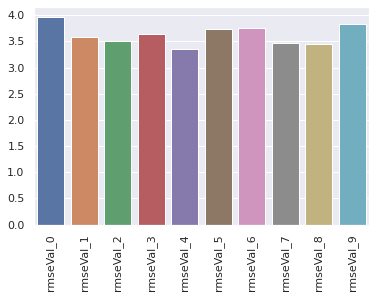

In [178]:
ax = sns.barplot(x=list(rmseVal_df.keys()), y= rmseVal_df_sqrt)#list(rmseVal_df.values()))

plt.xticks(rotation=90)
plt.show()

In [179]:
rmse_df_sqrt = []
for i in rmse_df.keys():
  rmse_df_sqrt.append(math.sqrt(rmse_df[i]))

rmse_df_sqrt

[3.8553582168924407,
 3.5926625097861704,
 3.5866287613750756,
 3.784051523613156,
 3.389192439720041,
 4.358468113416529,
 4.1006406448524055,
 3.8394442481431885,
 3.5319067116504024,
 4.195344225444457]

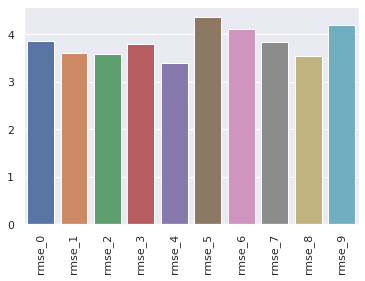

In [181]:
ax = sns.barplot(x=list(rmse_df.keys()), y= rmse_df_sqrt )

plt.xticks(rotation=90)
plt.show()

In [263]:
rmse_old = pd.Series(rmse_df_sqrt)
rmse_old.head()

0    3.855358
1    3.592663
2    3.586629
3    3.784052
4    3.389192
dtype: float64

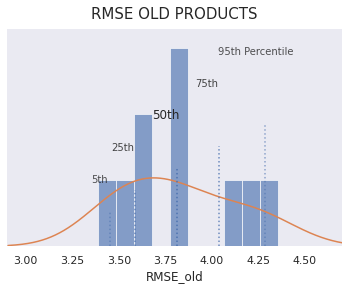

In [300]:
fig, ax = plt.subplots(figsize = (6,4))
    # Plot histogram
rmse_old.plot(kind = "hist", density = True, alpha = 0.65, bins = 10) # change density to true, because KDE uses density
    # Plot KDE
rmse_old.plot(kind = "kde")

    # Quantile lines
quant_5, quant_25, quant_50, quant_75, quant_95 = rmse_old.quantile(0.05), rmse_old.quantile(0.25), rmse_old.quantile(0.5), rmse_old.quantile(0.75), rmse_old.quantile(0.95)
    # [quantile, opacity, length]
quants = [[quant_5, 0.6, 0.16], [quant_25, 0.8, 0.26], [quant_50, 1, 0.36],  [quant_75, 0.8, 0.46], [quant_95, 0.6, 0.56]]
for i in quants:
    ax.axvline(i[0], alpha = i[1], ymax = i[2], linestyle = ":")


# X
ax.set_xlabel("RMSE_old")   
x_start, x_end = 2.9, 4.7
ax.set_xlim(x_start, x_end)

# Y
ax.set_ylim(0, 3.4)
ax.set_yticklabels([])
ax.set_ylabel("")

# Annotations
ax.text(quant_5-.1, 1, "5th", size = 10, alpha = 0.8)
ax.text(quant_25-.13, 1.5, "25th", size = 10, alpha = 0.85)
ax.text(quant_50-.13, 2, "50th", size = 12, alpha = 1)
ax.text(quant_75-.13, 2.5, "75th", size = 10, alpha = 0.85)
ax.text(quant_95-.25, 3, "95th Percentile", size = 10, alpha =.8)

# Overall
ax.grid(False)
ax.set_title("RMSE OLD PRODUCTS", size = 15, pad = 10)

    # Remove ticks and spines
ax.tick_params(left = False, bottom = False)
for ax, spine in ax.spines.items():
    spine.set_visible(False)
    
plt.show()

##### Here we just split the whole OLD data to train, validation, test. And kept the Topic as a new feature:

In [182]:
data_df["Topic"] = data_df["Topic"].astype('category')

In [183]:
x_tr_topic_df = data_df[(data_df['Date'] <= '2011-11-01')].drop(['Date','Description','Quantity'],axis = 1)
x_tr_topic_df

,StockCode,Year,Month,Week,Day,Weekday,is_weekend,Topic
0,10002,2010,12,48,1,2,0,6
1,10125,2010,12,48,1,2,0,2
2,10133,2010,12,48,1,2,0,9
3,16014,2010,12,48,1,2,0,8
4,16016,2010,12,48,1,2,0,8
...,...,...,...,...,...,...,...,...
163626,85152,2011,11,44,1,1,0,7
163627,85175,2011,11,44,1,1,0,6
163628,85187,2011,11,44,1,1,0,5
163629,85208,2011,11,44,1,1,0,2


In [184]:
y_tr_topic_df = data_df[(data_df['Date'] <= '2011-11-01')]['Quantity']
y_tr_topic_df.shape

(154971,)

In [185]:
x_val_topic_df = data_df[(data_df['Date']>'2011-11-01') & (data_df['Date']<='2011-12-01')].drop(['Date','Description','Quantity'],axis = 1)
x_val_topic_df

,StockCode,Year,Month,Week,Day,Weekday,is_weekend,Topic
163631,10080,2011,11,44,2,2,0,1
163633,11001,2011,11,44,2,2,0,9
163634,15034,2011,11,44,2,2,0,0
163635,15036,2011,11,44,2,2,0,0
163636,16014,2011,11,44,2,2,0,8
...,...,...,...,...,...,...,...,...
189750,85152,2011,12,48,1,3,0,7
189751,85176,2011,12,48,1,3,0,2
189752,85177,2011,12,48,1,3,0,2
189753,85227,2011,12,48,1,3,0,5


In [186]:
y_val_topic_df = data_df[(data_df['Date']>'2011-11-01') & (data_df['Date']<='2011-12-01')]['Quantity']
y_val_topic_df.shape

(21556,)

In [187]:
x_te_topic_df = data_df[(data_df['Date']>'2011-12-01')].drop(['Date','Description','Quantity'],axis = 1)
x_te_topic_df

,StockCode,Year,Month,Week,Day,Weekday,is_weekend,Topic
189755,15036,2011,12,48,2,4,0,0
189756,16236,2011,12,48,2,4,0,9
189757,16237,2011,12,48,2,4,0,9
189758,16238,2011,12,48,2,4,0,9
189759,20674,2011,12,48,2,4,0,4
...,...,...,...,...,...,...,...,...
196186,85038,2011,12,49,9,4,0,5
196187,85053,2011,12,49,9,4,0,6
196188,85066,2011,12,49,9,4,0,8
196189,85152,2011,12,49,9,4,0,7


In [188]:
y_te_topic_df = data_df[(data_df['Date']>'2011-12-01')]['Quantity']
y_te_topic_df.shape

(5364,)

In [189]:
import optuna
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
#optimization:
def objective(trial):



        param = {
            'metric': 'rmse', 
            'random_state': 48,
            'n_estimators': trial.suggest_int('n_estimators', 100, 200, 500),
            'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
            'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
            'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
            'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
            'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
             # 'max_depth': trial.suggest_categorical('max_depth', [10,20,100]),
            'num_leaves' : trial.suggest_int('num_leaves', 30, 200, 1000),  
            'min_child_samples': trial.suggest_int('min_child_samples', 10, 300),
            'cat_smooth' : trial.suggest_int('min_data_per_groups', 1, 100)
        }


        model_topic_df = LGBMRegressor(**param)
        model_topic_df.fit(x_tr_topic_df,y_tr_topic_df, eval_set=[(x_val_topic_df,y_val_topic_df)],early_stopping_rounds=100,verbose=False)
        pred_topic_df = model_topic_df.predict(x_te_topic_df)
        rmse_topic_df = mean_squared_error(y_te_topic_df, model_topic_df.predict(x_te_topic_df), squared=False)

        return rmse_topic_df    
    
    
    
    

In [190]:
# the objective of our fuction is to minimize the RMSE that's why direction='minimize':
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
params=study.best_params   


model_topic_df= LGBMRegressor(**params)
model_topic_df.fit(x_tr_topic_df,y_tr_topic_df,
                                        eval_set=[(x_val_topic_df,y_val_topic_df)],early_stopping_rounds=100,verbose=False)
pred_topic_df = model_topic_df.predict(x_te_topic_df)
rmse_topic_df = mean_squared_error(y_te_topic_df, model_topic_df.predict(x_te_topic_df), squared=False)
rmseVal_topic_df = mean_squared_error(y_val_topic_df, model_topic_df.predict(x_val_topic_df), squared=False)


[I 2022-03-22 02:47:17,613] A new study created in memory with name: no-name-2491f3b4-6e9e-495e-a2b8-fc4108ed990d
[I 2022-03-22 02:47:18,945] Trial 0 finished with value: 16.102087299335345 and parameters: {'n_estimators': 100, 'reg_alpha': 9.028890685516712, 'reg_lambda': 0.0016860818328014292, 'colsample_bytree': 0.3, 'subsample': 0.5, 'learning_rate': 0.008, 'num_leaves': 30, 'min_child_samples': 204, 'min_data_per_groups': 95}. Best is trial 0 with value: 16.102087299335345.
[I 2022-03-22 02:47:21,873] Trial 1 finished with value: 15.259768125740507 and parameters: {'n_estimators': 100, 'reg_alpha': 0.15516373960090282, 'reg_lambda': 0.0033973973839071313, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.014, 'num_leaves': 30, 'min_child_samples': 75, 'min_data_per_groups': 67}. Best is trial 1 with value: 15.259768125740507.
[I 2022-03-22 02:47:24,838] Trial 2 finished with value: 15.165757092359666 and parameters: {'n_estimators': 100, 'reg_alpha': 0.0040317986030339

Number of finished trials: 50
Best trial: {'n_estimators': 100, 'reg_alpha': 1.220757128210451, 'reg_lambda': 0.31937658931042495, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.02, 'num_leaves': 30, 'min_child_samples': 253, 'min_data_per_groups': 1}


In [191]:
math.sqrt(rmse_topic_df)

3.8573912036474693

In [192]:
model_topic_df

LGBMRegressor(colsample_bytree=0.8, learning_rate=0.02, min_child_samples=253,
              min_data_per_groups=1, num_leaves=30, reg_alpha=1.220757128210451,
              reg_lambda=0.31937658931042495, subsample=0.6)

#### Assign new products to old clusters based on Cossine similarity to average of the embedding of eeach cluster:

In [193]:
roberta_old_df = {}
for i in topics_df.keys():
    roberta_old_df["roberta_old_{0}".format(i)] = roberta_model.encode(list(set(topics_df[i]['Description'])))

In [194]:
roberta_old_df.keys()

dict_keys(['roberta_old_data_df_D0', 'roberta_old_data_df_D1', 'roberta_old_data_df_D2', 'roberta_old_data_df_D3', 'roberta_old_data_df_D4', 'roberta_old_data_df_D5', 'roberta_old_data_df_D6', 'roberta_old_data_df_D7', 'roberta_old_data_df_D8', 'roberta_old_data_df_D9'])

##### Calculate the average embedding for each cluster in old data (roberta_old_average, 768):

In [196]:
data_df.head()
#New_data1["Topic"] = "Null"
#New_data1["Roberta"] = "Null"
New_data1.head()

,Date,StockCode,Year,Month,Week,Day,Weekday,is_weekend,Quantity,UnitPrice,Sales,Description,Topic,Roberta
120864,2011-09-01,23376,2011,9,35,1,3,0,48,0.39,18.72,pack of 12 vintage christmas tissue,Null,Null
120865,2011-09-01,23378,2011,9,35,1,3,0,48,0.39,18.72,pack of 12 50's christmas tissues,Null,Null
120878,2011-09-01,23551,2011,9,35,1,3,0,12,0.39,4.68,pack of 12 paisley park tissues,Null,Null
122173,2011-09-04,23377,2011,9,35,4,6,1,12,0.39,4.68,pack of 12 dolly girl tissues,Null,Null
122174,2011-09-04,23393,2011,9,35,4,6,1,10,3.75,37.50,home sweet home cushion cover,Null,Null


In [197]:
for index, row in New_data1.iterrows():
    New_data1['Roberta'][index] = roberta_model.encode(New_data1["Description"][index])

In [198]:
roberta_old_ave = {}
roberta_old_average = {}
for i in (list(set(roberta_old_df.keys()))):
    roberta_old_ave[i] = []
    for j in roberta_old_df[i]:
        roberta_old_ave[i].append(j)  
    roberta_old_average[i] = list(np.mean(roberta_old_ave[i], axis=0))


In [199]:
len(list(roberta_old_average.values()))

10

#### Assign topic to each new product using cosine similarity of it's descrription and average robrta of each old clusters:

In [200]:
import re
for index, row in New_data1.iterrows(): 
    all_sentence_combinations = []
    for i in roberta_old_average.keys():
        all_sentence_combinations.append([util.cos_sim(roberta_old_average[i],New_data1['Roberta'][index]),(re.findall(r'(?<=_df_D)[^.\s]*',i)[0])+""])
    all_sentence_combinations = sorted(all_sentence_combinations, key=lambda x: x[0], reverse=True)
    #print(all_sentence_combinations[0][1])
    New_data1['Topic'][index] = all_sentence_combinations[0][1]

    

In [201]:
new_topics = pd.DataFrame(New_data1['Topic'].value_counts())
new_topics = new_topics.reset_index()
new_topics

,index,Topic
0,9,1244
1,2,1118
2,8,812
3,3,697
4,1,661
5,5,639
6,0,593
7,4,509
8,7,262
9,6,195


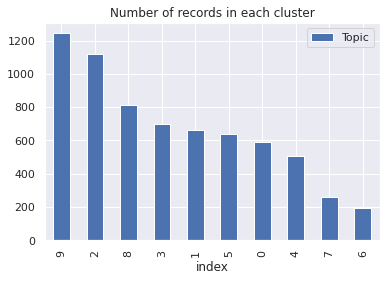

In [202]:
new_topics.plot(x='index', y='Topic', kind="bar")
plt.title("Number of records in each cluster")
plt.show()

In [203]:
New_data1.shape

(6730, 14)

#### Run LGBM on all new product, without topic clusters and descriptions: 

In [204]:
New_data1["StockCode"] = New_data1["StockCode"].astype('category')

In [205]:
x_tr_new_df = New_data1[New_data1['Date'] <= '2011-11-01'].drop(['Date','Description','Topic','Quantity','Roberta','Sales','UnitPrice'],axis = 1)

In [206]:
y_tr_new_df = New_data1[New_data1['Date'] <= '2011-11-01']['Quantity']

In [207]:
x_val_new_df = New_data1[(New_data1['Date'] > '2011-11-01') & (New_data1['Date'] <= '2011-12-01')].drop(['Date','Description','Topic','Quantity','Roberta','Sales','UnitPrice'],axis = 1)

In [208]:
y_val_new_df = New_data1[(New_data1['Date'] > '2011-11-01') & (New_data1['Date'] <= '2011-12-01')]['Quantity']

In [209]:
x_te_new_df = New_data1[ (New_data1['Date'] > '2011-12-01')].drop(['Date','Description','Topic','Quantity','Roberta','Sales','UnitPrice'],axis = 1)

In [210]:
y_te_new_df = New_data1[ (New_data1['Date'] > '2011-12-01')]['Quantity']

#### LGBM Model on all NEW products:

In [211]:
import optuna
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
#optimization:
def objective(trial):
    
    
    param = {
            'metric': 'rmse', 
            'random_state': 48,
            'n_estimators': trial.suggest_int('n_estimators', 100, 200, 500),
            'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
            'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
            'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
            'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
            'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
            # 'max_depth': trial.suggest_categorical('max_depth', [10,20,100]),
            'num_leaves' : trial.suggest_int('num_leaves', 30, 200, 1000),  
            'min_child_samples': trial.suggest_int('min_child_samples', 10, 300),
            'cat_smooth' : trial.suggest_int('min_data_per_groups', 1, 100)
    }
        
        
    model_new_df = LGBMRegressor(**param)
        
    model_new_df.fit(x_tr_new_df,y_tr_new_df, eval_set = [(x_val_new_df,y_val_new_df)], early_stopping_rounds=100,verbose=False)
    pred_new_df = model_new_df.predict(x_te_new_df)
    rmse_new_df = mean_squared_error(y_te_new_df, pred_new_df, squared=False)
    
    return rmse_new_df

In [212]:
# the objective of our fuction is to minimize the RMSE that's why direction='minimize':
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
params=study.best_params   


model_new_df= LGBMRegressor(**params)
model_new_df.fit(x_tr_new_df,y_tr_new_df, eval_set=[(x_val_new_df,y_val_new_df)],early_stopping_rounds=100,verbose=False)
pred_new_df = model_new_df.predict(x_te_new_df)
rmse_new_df = mean_squared_error(y_te_new_df, pred_new_df, squared=False)
rmseVal_new_df = mean_squared_error(y_val_new_df, model_new_df.predict(x_val_new_df), squared=False)



[I 2022-03-22 03:06:37,599] A new study created in memory with name: no-name-aa51444e-2978-49a8-ad5a-1ff8d5e7ae4b
[I 2022-03-22 03:06:37,702] Trial 0 finished with value: 16.4046243261585 and parameters: {'n_estimators': 100, 'reg_alpha': 5.37224869431834, 'reg_lambda': 0.015382616230694432, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.006, 'num_leaves': 30, 'min_child_samples': 128, 'min_data_per_groups': 17}. Best is trial 0 with value: 16.4046243261585.
[I 2022-03-22 03:06:37,752] Trial 1 finished with value: 16.679910799161625 and parameters: {'n_estimators': 100, 'reg_alpha': 4.532694943806422, 'reg_lambda': 1.773749379224942, 'colsample_bytree': 0.3, 'subsample': 0.5, 'learning_rate': 0.017, 'num_leaves': 30, 'min_child_samples': 166, 'min_data_per_groups': 69}. Best is trial 0 with value: 16.4046243261585.
[I 2022-03-22 03:06:37,842] Trial 2 finished with value: 16.333237264625044 and parameters: {'n_estimators': 100, 'reg_alpha': 0.16340244989278063, 'reg_lambd

Number of finished trials: 50
Best trial: {'n_estimators': 100, 'reg_alpha': 0.0035982733087977525, 'reg_lambda': 0.03775961257466403, 'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.014, 'num_leaves': 30, 'min_child_samples': 98, 'min_data_per_groups': 1}


In [213]:
math.sqrt(rmse_new_df)

4.019052380731443

In [214]:
y_te_new_df
pred_new_df
# Something is wwrong here, I have lots of same predictions for different stockcodes in different clusters. I probably made a mistake in trainig the LGBM model.?????????????????????????????????????????????????????????????

array([ 5.77916181, 20.20140625, 20.13789397, 11.00214973, 14.66973239,
       13.26704994, 26.55103368, 22.29709153,  9.59742336, 11.11120158,
        7.63443552,  9.59441791, 10.96545899, 10.94795075, 10.43427368,
        8.12649433,  6.32073335, 10.81489556,  6.78039347,  5.77916181,
        7.22960903,  6.30371679,  6.35007755, 14.12485189, 11.03757376,
        9.20528578, 13.56130714, 11.00315459, 11.00315459, 11.00315459,
       20.04754705, 12.5942333 ,  8.62285439, 13.04958876, 11.00315459,
       11.00315459, 11.00315459, 11.00315459,  6.30303153,  6.27943566,
        5.77916181, 11.00315459, 11.00315459, 11.00315459, 11.00315459,
       14.06382631, 18.19230194, 12.13649858, 11.00315459, 20.86634462,
       10.88817818, 11.00315459, 11.00315459, 11.00315459, 11.00315459,
       11.00315459, 22.52668109, 19.35256   , 12.6356169 , 26.55103368,
       26.38654019, 11.79718039, 18.68991749, 10.76229528,  7.97333949,
        7.42923602,  7.42923602,  6.30371679,  7.16753896,  6.56

#### Run LGBM only on new products, for each topic clusters: 

In [215]:
New_data1

,Date,StockCode,Year,Month,Week,Day,Weekday,is_weekend,Quantity,UnitPrice,Sales,Description,Topic,Roberta
120864,2011-09-01,23376,2011,9,35,1,3,0,48,0.390,18.72,pack of 12 vintage christmas tissue,0,"[0.119590655, -0.2360572, -0.6190889, 0.074358..."
120865,2011-09-01,23378,2011,9,35,1,3,0,48,0.390,18.72,pack of 12 50's christmas tissues,9,"[0.33933848, -0.093330994, -0.2763317, -0.2261..."
120878,2011-09-01,23551,2011,9,35,1,3,0,12,0.390,4.68,pack of 12 paisley park tissues,9,"[-0.07086653, 0.09809898, 0.19068697, 0.695377..."
122173,2011-09-04,23377,2011,9,35,4,6,1,12,0.390,4.68,pack of 12 dolly girl tissues,1,"[0.5356256, 0.066150784, -0.21000478, 0.085830..."
122174,2011-09-04,23393,2011,9,35,4,6,1,10,3.750,37.50,home sweet home cushion cover,2,"[-0.40332657, 1.0793754, -0.36360645, 0.766857..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196160,2011-12-09,23570,2011,12,49,9,4,0,24,1.250,30.00,traditional pick up sticks game,9,"[-0.3697044, -0.24335967, 0.9424509, 0.5894271..."
196161,2011-12-09,23571,2011,12,49,9,4,0,12,1.650,19.80,traditional naughts & crosses,0,"[0.53559995, 1.0924447, -0.42377615, 0.4970184..."
196162,2011-12-09,23581,2011,12,49,9,4,0,50,1.935,92.40,jumbo bag paisley park,1,"[-0.44290882, 0.23070243, -0.26067492, 1.23004..."
196163,2011-12-09,23598,2011,12,49,9,4,0,6,2.950,17.70,paper bunting vintage party,2,"[-0.28610066, 0.26283944, -0.5755605, 0.512798..."


In [216]:
# change Topic type to category:
New_data1["Topic"] = New_data1["Topic"].astype('category')

In [217]:
topics_new_df = {}
for i in set(New_data1["Topic"]):
    if (New_data1[New_data1["Topic"]== i].empty):
        pass
    else:
        topics_new_df["New_data_D{0}".format(i)] = New_data1[New_data1["Topic"]== i]

In [218]:
x_tr_only_new_df = {}
for i in topics_new_df.keys():
    x_tr_only_new_df[i] =  topics_new_df[i][(topics_new_df[i]['Date'] <= '2011-11-01')].drop(['Date','Description','Topic','Quantity','Roberta','Sales','UnitPrice'],axis = 1)
    x_tr_only_new_df[i]["StockCode"] =  x_tr_only_new_df[i]["StockCode"].astype('category')

In [219]:
y_tr_only_new_df = {}
for i in topics_new_df.keys():
    y_tr_only_new_df[i] = topics_new_df[i][(topics_new_df[i]['Date'] <= '2011-11-01')]['Quantity']

In [220]:
x_val_only_new_df = {}
for i in topics_new_df.keys():
    x_val_only_new_df[i] =  topics_new_df[i][(topics_new_df[i]['Date'] > '2011-11-01') & (topics_new_df[i]['Date'] <= '2011-12-01')].drop(['Date','Description','Topic','Quantity','Roberta','Sales','UnitPrice'],axis = 1)
    x_val_only_new_df[i]["StockCode"] =  x_val_only_new_df[i]["StockCode"].astype('category')

In [221]:
y_val_only_new_df = {}
for i in topics_new_df.keys():
    y_val_only_new_df[i] =  topics_new_df[i][(topics_new_df[i]['Date'] > '2011-11-01') & (topics_new_df[i]['Date'] <= '2011-12-01')]['Quantity']

In [222]:
x_te_only_new_df = {}
for i in topics_new_df.keys():
    x_te_only_new_df[i] =  topics_new_df[i][(topics_new_df[i]['Date']> '2011-12-01')].drop(['Date','Description','Topic','Quantity','Roberta','Sales','UnitPrice'],axis = 1)
    x_te_only_new_df[i]["StockCode"] = x_te_only_new_df[i]["StockCode"].astype('category')

In [223]:
y_te_only_new_df = {}
for i in topics_new_df.keys():
    y_te_only_new_df[i] = topics_new_df[i][(topics_new_df[i]['Date'] > '2011-12-01')]['Quantity']   

In [224]:
import optuna
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
model_only_new_withTopic_df = {}
pred_only_new_withTopic_df = {}
rmse_only_new_withTopic_df = {}
rmseVal_only_new_withTopic_df = {}
global_y_only_new_withTopic_df = []
global_pred_only_new_withTopic_df = []

for i in topics_new_df.keys():
    #optimization:
    params = {}
    def objective(trial):


        param = {
            'metric': 'rmse', 
            'random_state': 48,
            'n_estimators': trial.suggest_int('n_estimators', 100, 200, 500),
            'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
            'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
            'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
            'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
            'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
            # 'max_depth': trial.suggest_categorical('max_depth', [10,20,100]),
            'num_leaves' : trial.suggest_int('num_leaves', 30, 200, 1000),  
            'min_child_samples': trial.suggest_int('min_child_samples', 10, 300),
            'cat_smooth' : trial.suggest_int('min_data_per_groups', 1, 100)
        }

        
        if (x_tr_only_new_df[i].empty or y_tr_only_new_df[i].empty or x_val_only_new_df[i].empty or y_val_only_new_df[i].empty or x_te_only_new_df[i].empty or y_te_only_new_df[i].empty):
            pass
        
        else:
            
            model_only_new_withTopic_df[i] = LGBMRegressor(**param)
            model_only_new_withTopic_df[i].fit(x_tr_only_new_df[i],y_tr_only_new_df[i],
                                            eval_set=[(x_val_only_new_df[i],y_val_only_new_df[i])],early_stopping_rounds=100,verbose=False)
            pred_only_new_withTopic_df[i] = model_only_new_withTopic_df[i].predict(x_te_only_new_df[i])
            rmse_only_new_withTopic_df[i] = mean_squared_error(y_te_only_new_df[i],  model_only_new_withTopic_df[i].predict(x_te_only_new_df[i]), squared=False)
            
            return rmse_only_new_withTopic_df[i]
    
    
    if (x_tr_only_new_df[i].empty or y_tr_only_new_df[i].empty or x_val_only_new_df[i].empty or y_val_only_new_df[i].empty or x_te_only_new_df[i].empty or y_te_only_new_df[i].empty):
        pass
    else:    
    
        study = optuna.create_study(direction='minimize')
        study.optimize(objective, n_trials=50)
        print('Number of finished trials:', len(study.trials))
        print('Best trial:', study.best_trial.params)
        params=study.best_params   


        model_only_new_withTopic_df[i] = LGBMRegressor(**params)
        model_only_new_withTopic_df[i].fit(x_tr_only_new_df[i],y_tr_only_new_df[i], eval_set=[(x_val_only_new_df[i],y_val_only_new_df[i])],early_stopping_rounds=100,verbose=False)
        pred_only_new_withTopic_df[i] = model_only_new_withTopic_df[i].predict(x_te_only_new_df[i])
        rmse_only_new_withTopic_df[i] = mean_squared_error(y_te_only_new_df[i], model_only_new_withTopic_df[i].predict(x_te_only_new_df[i]), squared=False)
        global_y_only_new_withTopic_df.append(list(y_te_only_new_df[i]))
        global_pred_only_new_withTopic_df.append(list(pred_only_new_withTopic_df[i]))

            
            

[I 2022-03-22 03:07:19,674] A new study created in memory with name: no-name-a4199c17-6263-4f22-8c72-496e909a6528
[I 2022-03-22 03:07:19,730] Trial 0 finished with value: 21.3205856409621 and parameters: {'n_estimators': 100, 'reg_alpha': 0.04477371815778019, 'reg_lambda': 0.016327906981752457, 'colsample_bytree': 0.6, 'subsample': 0.4, 'learning_rate': 0.014, 'num_leaves': 30, 'min_child_samples': 28, 'min_data_per_groups': 37}. Best is trial 0 with value: 21.3205856409621.
[I 2022-03-22 03:07:19,770] Trial 1 finished with value: 21.3321112230902 and parameters: {'n_estimators': 100, 'reg_alpha': 0.017222205242928983, 'reg_lambda': 0.14115178243157295, 'colsample_bytree': 0.3, 'subsample': 0.4, 'learning_rate': 0.008, 'num_leaves': 30, 'min_child_samples': 209, 'min_data_per_groups': 51}. Best is trial 0 with value: 21.3205856409621.
[I 2022-03-22 03:07:19,813] Trial 2 finished with value: 21.3321112230902 and parameters: {'n_estimators': 100, 'reg_alpha': 0.09468555097749129, 'reg_la

Number of finished trials: 50
Best trial: {'n_estimators': 100, 'reg_alpha': 0.7339610042878489, 'reg_lambda': 0.007722994145278395, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.02, 'num_leaves': 30, 'min_child_samples': 157, 'min_data_per_groups': 20}


[I 2022-03-22 03:07:22,367] Trial 4 finished with value: 16.382702273957964 and parameters: {'n_estimators': 100, 'reg_alpha': 0.010745674407513348, 'reg_lambda': 8.446236864433537, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.006, 'num_leaves': 30, 'min_child_samples': 286, 'min_data_per_groups': 18}. Best is trial 1 with value: 15.56626643328379.
[I 2022-03-22 03:07:22,420] Trial 5 finished with value: 16.511088957432676 and parameters: {'n_estimators': 100, 'reg_alpha': 6.558978175227, 'reg_lambda': 4.309467228384215, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.014, 'num_leaves': 30, 'min_child_samples': 15, 'min_data_per_groups': 47}. Best is trial 1 with value: 15.56626643328379.
[I 2022-03-22 03:07:22,453] Trial 6 finished with value: 16.382702273957964 and parameters: {'n_estimators': 100, 'reg_alpha': 0.004706927940813854, 'reg_lambda': 0.014022959683141758, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.02, 'num_leaves': 30, 'm

Number of finished trials: 50
Best trial: {'n_estimators': 100, 'reg_alpha': 0.05113209591699992, 'reg_lambda': 0.018333064825020985, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.008, 'num_leaves': 30, 'min_child_samples': 63, 'min_data_per_groups': 11}


[I 2022-03-22 03:07:24,954] Trial 4 finished with value: 11.271699641405332 and parameters: {'n_estimators': 100, 'reg_alpha': 4.899962724587725, 'reg_lambda': 4.566168310751344, 'colsample_bytree': 0.3, 'subsample': 0.4, 'learning_rate': 0.01, 'num_leaves': 30, 'min_child_samples': 236, 'min_data_per_groups': 74}. Best is trial 0 with value: 11.271699641405332.
[I 2022-03-22 03:07:24,987] Trial 5 finished with value: 11.271699641405332 and parameters: {'n_estimators': 100, 'reg_alpha': 4.936123056260418, 'reg_lambda': 0.5722503583385136, 'colsample_bytree': 0.3, 'subsample': 0.5, 'learning_rate': 0.02, 'num_leaves': 30, 'min_child_samples': 161, 'min_data_per_groups': 100}. Best is trial 0 with value: 11.271699641405332.
[I 2022-03-22 03:07:25,023] Trial 6 finished with value: 11.271699641405332 and parameters: {'n_estimators': 100, 'reg_alpha': 0.5382637397900458, 'reg_lambda': 0.0019253397287514913, 'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.008, 'num_leaves': 30,

Number of finished trials: 50
Best trial: {'n_estimators': 100, 'reg_alpha': 0.024629768620215903, 'reg_lambda': 0.03164102224063224, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.02, 'num_leaves': 30, 'min_child_samples': 24, 'min_data_per_groups': 71}


[I 2022-03-22 03:07:27,263] Trial 4 finished with value: 14.550448991092653 and parameters: {'n_estimators': 100, 'reg_alpha': 0.03171450817265012, 'reg_lambda': 7.560586952687759, 'colsample_bytree': 1.0, 'subsample': 0.4, 'learning_rate': 0.02, 'num_leaves': 30, 'min_child_samples': 148, 'min_data_per_groups': 29}. Best is trial 2 with value: 14.148010161275156.
[I 2022-03-22 03:07:27,305] Trial 5 finished with value: 13.80498762477164 and parameters: {'n_estimators': 100, 'reg_alpha': 3.092176359365223, 'reg_lambda': 1.9907973559496357, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.017, 'num_leaves': 30, 'min_child_samples': 88, 'min_data_per_groups': 37}. Best is trial 5 with value: 13.80498762477164.
[I 2022-03-22 03:07:27,348] Trial 6 finished with value: 14.550448991092653 and parameters: {'n_estimators': 100, 'reg_alpha': 9.81703618141559, 'reg_lambda': 0.0014381649255214045, 'colsample_bytree': 0.5, 'subsample': 0.4, 'learning_rate': 0.017, 'num_leaves': 30, 'm

Number of finished trials: 50
Best trial: {'n_estimators': 100, 'reg_alpha': 0.09872705092632109, 'reg_lambda': 0.0016609077011862194, 'colsample_bytree': 0.3, 'subsample': 0.8, 'learning_rate': 0.02, 'num_leaves': 30, 'min_child_samples': 42, 'min_data_per_groups': 7}


[I 2022-03-22 03:07:29,830] Trial 3 finished with value: 15.748812641823257 and parameters: {'n_estimators': 100, 'reg_alpha': 0.03612741036861451, 'reg_lambda': 1.9083678469443799, 'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.02, 'num_leaves': 30, 'min_child_samples': 197, 'min_data_per_groups': 99}. Best is trial 1 with value: 15.637951570977405.
[I 2022-03-22 03:07:29,870] Trial 4 finished with value: 15.738998403508504 and parameters: {'n_estimators': 100, 'reg_alpha': 0.1713959802666466, 'reg_lambda': 0.00834620352638829, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.017, 'num_leaves': 30, 'min_child_samples': 78, 'min_data_per_groups': 47}. Best is trial 1 with value: 15.637951570977405.
[I 2022-03-22 03:07:29,913] Trial 5 finished with value: 15.722748160629587 and parameters: {'n_estimators': 100, 'reg_alpha': 1.4713147014174157, 'reg_lambda': 0.11824712585325993, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.008, 'num_leaves': 3

Number of finished trials: 50
Best trial: {'n_estimators': 100, 'reg_alpha': 0.005737012102855184, 'reg_lambda': 0.8426714717800251, 'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.01, 'num_leaves': 30, 'min_child_samples': 106, 'min_data_per_groups': 6}


[I 2022-03-22 03:07:32,571] Trial 3 finished with value: 20.947923282220554 and parameters: {'n_estimators': 100, 'reg_alpha': 0.4577270107999358, 'reg_lambda': 0.050110108196140556, 'colsample_bytree': 0.6, 'subsample': 0.4, 'learning_rate': 0.014, 'num_leaves': 30, 'min_child_samples': 250, 'min_data_per_groups': 67}. Best is trial 2 with value: 20.879487744396645.
[I 2022-03-22 03:07:32,622] Trial 4 finished with value: 20.930283712868313 and parameters: {'n_estimators': 100, 'reg_alpha': 0.00292051360737128, 'reg_lambda': 0.4249550866065428, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.014, 'num_leaves': 30, 'min_child_samples': 25, 'min_data_per_groups': 42}. Best is trial 2 with value: 20.879487744396645.
[I 2022-03-22 03:07:32,661] Trial 5 finished with value: 20.904465990366237 and parameters: {'n_estimators': 100, 'reg_alpha': 1.3589082045727008, 'reg_lambda': 0.03252985032920126, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.02, 'num_leaves': 

Number of finished trials: 50
Best trial: {'n_estimators': 100, 'reg_alpha': 0.12973153711159596, 'reg_lambda': 0.11666127974880992, 'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.02, 'num_leaves': 30, 'min_child_samples': 262, 'min_data_per_groups': 1}


[I 2022-03-22 03:07:35,491] Trial 4 finished with value: 6.14649589316595 and parameters: {'n_estimators': 100, 'reg_alpha': 0.14780821530665628, 'reg_lambda': 0.8664083207999098, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.006, 'num_leaves': 30, 'min_child_samples': 244, 'min_data_per_groups': 89}. Best is trial 2 with value: 6.146107947209959.
[I 2022-03-22 03:07:35,534] Trial 5 finished with value: 6.1934312010293695 and parameters: {'n_estimators': 100, 'reg_alpha': 0.026410198838665994, 'reg_lambda': 2.4557695333156033, 'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.01, 'num_leaves': 30, 'min_child_samples': 42, 'min_data_per_groups': 67}. Best is trial 2 with value: 6.146107947209959.
[I 2022-03-22 03:07:35,568] Trial 6 finished with value: 6.14649589316595 and parameters: {'n_estimators': 100, 'reg_alpha': 0.40008331384425405, 'reg_lambda': 0.22807279760922367, 'colsample_bytree': 0.5, 'subsample': 0.4, 'learning_rate': 0.008, 'num_leaves': 30, '

Number of finished trials: 50
Best trial: {'n_estimators': 100, 'reg_alpha': 0.6886618289367133, 'reg_lambda': 0.015228437301937398, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.02, 'num_leaves': 30, 'min_child_samples': 10, 'min_data_per_groups': 90}


[I 2022-03-22 03:07:37,925] Trial 3 finished with value: 10.862533414569217 and parameters: {'n_estimators': 100, 'reg_alpha': 1.5170819288174326, 'reg_lambda': 2.2435504911683037, 'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.02, 'num_leaves': 30, 'min_child_samples': 129, 'min_data_per_groups': 71}. Best is trial 0 with value: 10.666181790746617.
[I 2022-03-22 03:07:37,962] Trial 4 finished with value: 10.862791057937706 and parameters: {'n_estimators': 100, 'reg_alpha': 0.03460665215129968, 'reg_lambda': 0.06522017155611275, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.017, 'num_leaves': 30, 'min_child_samples': 237, 'min_data_per_groups': 8}. Best is trial 0 with value: 10.666181790746617.
[I 2022-03-22 03:07:37,999] Trial 5 finished with value: 10.862784864175389 and parameters: {'n_estimators': 100, 'reg_alpha': 0.0041435874230391825, 'reg_lambda': 0.04167928837421656, 'colsample_bytree': 0.3, 'subsample': 0.7, 'learning_rate': 0.006, 'num_leaves'

Number of finished trials: 50
Best trial: {'n_estimators': 100, 'reg_alpha': 0.0016416160792282672, 'reg_lambda': 0.09237711742507225, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.02, 'num_leaves': 30, 'min_child_samples': 21, 'min_data_per_groups': 43}


[I 2022-03-22 03:07:41,177] Trial 4 finished with value: 17.898492309018803 and parameters: {'n_estimators': 100, 'reg_alpha': 8.611007736620804, 'reg_lambda': 0.028257641950988923, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.01, 'num_leaves': 30, 'min_child_samples': 195, 'min_data_per_groups': 57}. Best is trial 0 with value: 17.898492309018803.
[I 2022-03-22 03:07:41,220] Trial 5 finished with value: 17.82888971270709 and parameters: {'n_estimators': 100, 'reg_alpha': 0.026523558509942, 'reg_lambda': 0.05726770445545617, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.017, 'num_leaves': 30, 'min_child_samples': 88, 'min_data_per_groups': 95}. Best is trial 5 with value: 17.82888971270709.
[I 2022-03-22 03:07:41,254] Trial 6 finished with value: 17.898492309018803 and parameters: {'n_estimators': 100, 'reg_alpha': 0.016219086973745113, 'reg_lambda': 0.024079327193452984, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.02, 'num_leaves': 30

Number of finished trials: 50
Best trial: {'n_estimators': 100, 'reg_alpha': 0.022812118873646193, 'reg_lambda': 0.046263790599392354, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.017, 'num_leaves': 30, 'min_child_samples': 73, 'min_data_per_groups': 17}


[I 2022-03-22 03:07:44,298] Trial 1 finished with value: 12.29756477563091 and parameters: {'n_estimators': 100, 'reg_alpha': 0.009560681086080764, 'reg_lambda': 0.002034718402375533, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.006, 'num_leaves': 30, 'min_child_samples': 184, 'min_data_per_groups': 56}. Best is trial 0 with value: 12.297427757743813.
[I 2022-03-22 03:07:44,351] Trial 2 finished with value: 12.29748823889948 and parameters: {'n_estimators': 100, 'reg_alpha': 0.001631881813388005, 'reg_lambda': 0.419977778055536, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.01, 'num_leaves': 30, 'min_child_samples': 202, 'min_data_per_groups': 64}. Best is trial 0 with value: 12.297427757743813.
[I 2022-03-22 03:07:44,406] Trial 3 finished with value: 12.291018583420957 and parameters: {'n_estimators': 100, 'reg_alpha': 0.009718556643342355, 'reg_lambda': 9.478879855479105, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.02, 'num_leaves': 

Number of finished trials: 50
Best trial: {'n_estimators': 100, 'reg_alpha': 2.480480796503257, 'reg_lambda': 2.3189934059429778, 'colsample_bytree': 0.8, 'subsample': 0.8, 'learning_rate': 0.02, 'num_leaves': 30, 'min_child_samples': 76, 'min_data_per_groups': 26}


In [ ]:
#rmse_only_new_withTopic_df

{'New_data_D1': 10.769105235467286,
 'New_data_D6': 11.982607897416766,
 'New_data_D0': 12.398854194112,
 'New_data_D9': 11.144663026206597,
 'New_data_D4': 15.238753509723079,
 'New_data_D2': 12.360199355370987,
 'New_data_D7': 16.12534656703913,
 'New_data_D5': 18.389468264776816,
 'New_data_D8': 22.274151366573175,
 'New_data_D3': 6.0005410074652}

In [225]:
global_pred_only_new_withTopic = []
for i in (global_pred_only_new_withTopic_df):
    for j in i:
        global_pred_only_new_withTopic.append(j)
    
global_y_only_new_withTopic = []
for i in (global_y_only_new_withTopic_df):
    for j in i:
        global_y_only_new_withTopic.append(j)

#### finding the RMSE without MEAN:

In [226]:
math.sqrt(mean_squared_error(global_y_only_new_withTopic, global_pred_only_new_withTopic, squared=False))

4.034044531439186

In [227]:
len(global_pred_only_new_withTopic)

674

In [228]:
#To merge the stockcodes and their predictions for all clusters together in one dataframe:
import re
D_with_cluster = {}
for i in topics_new_df.keys():
    if (x_te_only_new_df[i].empty):
        pass
    else:
        D_with_cluster[i] = pd.DataFrame({'StockCode':x_te_only_new_df[i]['StockCode'],
                       'Quantity':y_te_only_new_df[i],
                       'pred_with_cluster': pred_only_new_withTopic_df[i],
                       'Topic': re.findall(r'(?<=_data_D)[^.\s]*',i)[0]})
        

new_df_with_cluster = pd.DataFrame()
for i in D_with_cluster.keys():
    new_df_with_cluster = pd.concat([D_with_cluster[i],new_df_with_cluster])
new_df_with_cluster

,StockCode,Quantity,pred_with_cluster,Topic
190476,23388,2,8.202227,2
190480,23393,10,9.997461,2
190481,23395,2,9.225942,2
190482,23396,4,8.508572,2
190489,23411,6,6.158950,2
...,...,...,...,...
195701,23681,34,15.644188,1
196130,23389,8,15.834652,1
196131,23390,4,15.644188,1
196162,23581,50,15.644188,1


In [229]:
x_te_only_new_df['New_data_D2']
#y_te_only_new_df['New_data_D2']
#Getting the same prediction for the all stockcodes in a cluster???????????????????????????????????????????????????????????????????????????
pred_only_new_withTopic_df['New_data_D2']
#global_pred_only_new_withTopic_df[1]

array([ 8.20222711,  9.9974608 ,  9.22594242,  8.50857186,  6.15895006,
       17.23336028,  9.81305649, 12.85035276,  6.66241177,  6.15895006,
        6.15895006,  6.15895006,  6.15895006,  6.15895006,  6.15895006,
        9.06868779,  5.23017705,  8.29716941,  7.57979885,  5.23017705,
        5.23017705, 16.30458727,  8.88428348, 11.92157975, 16.30458727,
        5.23017705,  7.63995706,  8.92654458,  5.23017705,  5.23017705,
        5.23017705,  5.23017705,  5.23017705,  5.23017705,  6.33209639,
        8.6449875 ,  6.33209639,  6.33209639, 16.74847852, 13.09452816,
       16.74847852,  6.33209639,  8.31301881,  7.60758712,  6.33209639,
        6.33209639,  6.33209639,  6.33209639,  6.33209639,  6.33209639,
        6.33209639,  6.33209639,  6.23904161,  8.50282296, 10.0308599 ,
        8.72945825,  8.02597136, 16.74847852, 10.14355819, 13.00194621,
        6.18993185,  8.76665639,  6.18993185,  7.46542258,  6.18993185,
        6.18993185,  6.18993185,  6.18993185,  6.18993185,  6.18

In [230]:
new_df_with_cluster['SE_with_cluster'] = ((new_df_with_cluster['pred_with_cluster'] - new_df_with_cluster['Quantity']) ** 2)
new_df_with_cluster


,StockCode,Quantity,pred_with_cluster,Topic,SE_with_cluster
190476,23388,2,8.202227,2,38.467621
190480,23393,10,9.997461,2,0.000006
190481,23395,2,9.225942,2,52.214244
190482,23396,4,8.508572,2,20.327220
190489,23411,6,6.158950,2,0.025265
...,...,...,...,...,...
195701,23681,34,15.644188,1,336.935817
196130,23389,8,15.834652,1,61.381777
196131,23390,4,15.644188,1,135.587125
196162,23581,50,15.644188,1,1180.321786


In [231]:
RMSE_with_cluster = np.sqrt(new_df_with_cluster['SE_with_cluster'].mean())
RMSE_with_cluster

16.2735152816344

In [232]:
mean_squared_error(new_df_with_cluster['pred_with_cluster'],new_df_with_cluster['Quantity'], squared=False)

16.2735152816344

In [233]:
new_df_with_cluster_grouped = pd.DataFrame(new_df_with_cluster.groupby(['StockCode']).agg({'Topic': 'first',  'SE_with_cluster':'mean'}))
#(lambda x: list(x))
new_df_with_cluster_grouped = new_df_with_cluster_grouped.reset_index()
new_df_with_cluster_grouped = new_df_with_cluster_grouped.dropna()
new_df_with_cluster_grouped

,StockCode,Topic,SE_with_cluster
4,23058,0,51.168284
5,23074,8,37.853232
6,23113,5,15.524484
7,23114,2,11.291814
8,23115,5,33.732543
9,23116,2,28.431252
10,23117,9,129.831434
11,23303,5,22.543477
12,23304,5,22.543477
13,23305,5,22.543477


In [234]:
new_df_with_cluster_grouped["RMSE_with_cluster"] = np.sqrt(new_df_with_cluster_grouped["SE_with_cluster"])
new_df_with_cluster_grouped

,StockCode,Topic,SE_with_cluster,RMSE_with_cluster
4,23058,0,51.168284,7.153201
5,23074,8,37.853232,6.152498
6,23113,5,15.524484,3.940112
7,23114,2,11.291814,3.360329
8,23115,5,33.732543,5.807972
9,23116,2,28.431252,5.332096
10,23117,9,129.831434,11.394360
11,23303,5,22.543477,4.747997
12,23304,5,22.543477,4.747997
13,23305,5,22.543477,4.747997


In [ ]:
#stockcodes and their predictions for all new products (without clustering):

In [235]:
test_new = New_data1[(New_data1['Date'] > '2011-12-01')].drop(['Date','Description','Year','Month','Week','Day','Weekday','is_weekend','Roberta','Sales','UnitPrice'],axis = 1)
test_new

,StockCode,Quantity,Topic
190339,23117,1,9
190469,23365,18,9
190470,23367,9,9
190471,23369,18,9
190472,23370,2,9
...,...,...,...
196160,23570,24,9
196161,23571,12,0
196162,23581,50,1
196163,23598,6,2


In [236]:
test_new['pred_no_cluster'] = pred_new_df
test_new['SE_no_cluster'] = ((test_new['pred_no_cluster'] - test_new['Quantity']) ** 2)
test_new

,StockCode,Quantity,Topic,pred_no_cluster,SE_no_cluster
190339,23117,1,9,5.779162,22.840388
190469,23365,18,9,20.201406,4.846189
190470,23367,9,9,20.137894,124.052682
190471,23369,18,9,11.002150,48.969908
190472,23370,2,9,14.669732,160.522119
...,...,...,...,...,...
196160,23570,24,9,10.790709,174.485364
196161,23571,12,0,10.790709,1.462384
196162,23581,50,1,10.790709,1537.368485
196163,23598,6,2,10.790709,22.950895


In [237]:
RMSE_no_cluster = np.sqrt(test_new["SE_no_cluster"].mean())
RMSE_no_cluster

16.15278203906308

In [238]:
mean_squared_error(test_new['pred_no_cluster'],test_new['Quantity'], squared=False)

16.152782039063084

In [239]:
test_new['RMSE_topic_old'] = "Null"

In [240]:
for index, row in test_new.iterrows():
    for i in range(len(rmse_df.keys())):
        if (row['Topic'] == str(i) ):
            test_new['RMSE_topic_old'][index] = rmse_df["rmse_{0}".format(i)]

In [241]:
test_new

,StockCode,Quantity,Topic,pred_no_cluster,SE_no_cluster,RMSE_topic_old
190339,23117,1,9,5.779162,22.840388,17.600913
190469,23365,18,9,20.201406,4.846189,17.600913
190470,23367,9,9,20.137894,124.052682,17.600913
190471,23369,18,9,11.002150,48.969908,17.600913
190472,23370,2,9,14.669732,160.522119,17.600913
...,...,...,...,...,...,...
196160,23570,24,9,10.790709,174.485364,17.600913
196161,23571,12,0,10.790709,1.462384,14.863787
196162,23581,50,1,10.790709,1537.368485,12.907224
196163,23598,6,2,10.790709,22.950895,12.863906


In [242]:
test_new["StockCode"] = test_new["StockCode"].astype('category')
test_new["RMSE_topic_old"] = test_new["RMSE_topic_old"].astype('float64')
test_new["SE_no_cluster"] = test_new["SE_no_cluster"].astype('float64')
test_new.dtypes

StockCode          category
Quantity              int64
Topic              category
pred_no_cluster     float64
SE_no_cluster       float64
RMSE_topic_old      float64
dtype: object

In [243]:
test_new["RMSE_topic_old"].mean() 

14.814700222727714

In [244]:
print(pd.__version__)

1.3.5


In [ ]:
#!pip install -U pandas

In [245]:
test_new_grouped = pd.DataFrame(test_new.groupby(['StockCode']).agg({'Topic': 'first',  'SE_no_cluster':'mean','RMSE_topic_old':'mean'}))
#(lambda x: list(x))
test_new_grouped = test_new_grouped.reset_index()
test_new_grouped = test_new_grouped.dropna()
test_new_grouped

,StockCode,Topic,SE_no_cluster,RMSE_topic_old
4,23058,0,121.821821,14.863787
5,23074,8,34.823798,12.474365
6,23113,5,8.415160,18.996244
7,23114,2,18.427836,12.863906
8,23115,5,26.888979,18.996244
9,23116,2,120.717441,12.863906
10,23117,9,24.496401,17.600913
11,23303,5,0.000165,18.996244
12,23304,5,0.014084,18.996244
13,23305,5,0.014084,18.996244


In [246]:
test_new_grouped["RMSE_no_cluster"] = np.sqrt(test_new_grouped["SE_no_cluster"])
test_new_grouped

,StockCode,Topic,SE_no_cluster,RMSE_topic_old,RMSE_no_cluster
4,23058,0,121.821821,14.863787,11.037292
5,23074,8,34.823798,12.474365,5.901169
6,23113,5,8.415160,18.996244,2.900890
7,23114,2,18.427836,12.863906,4.292766
8,23115,5,26.888979,18.996244,5.185458
9,23116,2,120.717441,12.863906,10.987149
10,23117,9,24.496401,17.600913,4.949384
11,23303,5,0.000165,18.996244,0.012851
12,23304,5,0.014084,18.996244,0.118674
13,23305,5,0.014084,18.996244,0.118674


In [ ]:
# I think we don't need to calculate the mean agian here:
#test_new_grouped["RMSE_no_cluster"].mean()

In [ ]:
#Now we need to match these two dataframesbased on their StockCodes: new_df_with_cluster_grouped and test_new_grouped:

In [247]:
test_new_grouped.shape

(195, 5)

In [248]:
final_df = pd.merge(test_new_grouped, new_df_with_cluster_grouped, on ='StockCode')
final_df = final_df.drop(['Topic_y'], axis = 1)
final_df

,StockCode,Topic_x,SE_no_cluster,RMSE_topic_old,RMSE_no_cluster,SE_with_cluster,RMSE_with_cluster
0,23058,0,121.821821,14.863787,11.037292,51.168284,7.153201
1,23074,8,34.823798,12.474365,5.901169,37.853232,6.152498
2,23113,5,8.415160,18.996244,2.900890,15.524484,3.940112
3,23114,2,18.427836,12.863906,4.292766,11.291814,3.360329
4,23115,5,26.888979,18.996244,5.185458,33.732543,5.807972
5,23116,2,120.717441,12.863906,10.987149,28.431252,5.332096
6,23117,9,24.496401,17.600913,4.949384,129.831434,11.394360
7,23303,5,0.000165,18.996244,0.012851,22.543477,4.747997
8,23304,5,0.014084,18.996244,0.118674,22.543477,4.747997
9,23305,5,0.014084,18.996244,0.118674,22.543477,4.747997


In [249]:
new_df_with_cluster[new_df_with_cluster['StockCode'] == '23305']
#new_df_with_cluster[new_df_with_cluster['StockCode'] == '23305']

,StockCode,Quantity,pred_with_cluster,Topic,SE_with_cluster
192535,23305,12,7.252003,5,22.543477
193618,23305,12,7.252003,5,22.543477


In [250]:
# Scatter plot x= no clustr, y = with cluster 

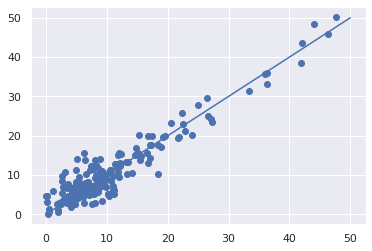

In [251]:
plt.scatter(final_df['RMSE_no_cluster'], final_df['RMSE_with_cluster'])
plt.plot([0,50],[0,50])

(array([ 2.,  1.,  2.,  1.,  3., 11.,  9., 12., 10., 25., 34., 29., 20.,
        16.,  8.,  2.,  5.,  4.,  0.,  1.]),
 array([-9.27225144, -8.39673973, -7.52122803, -6.64571632, -5.77020462,
        -4.89469291, -4.0191812 , -3.1436695 , -2.26815779, -1.39264609,
        -0.51713438,  0.35837732,  1.23388903,  2.10940074,  2.98491244,
         3.86042415,  4.73593585,  5.61144756,  6.48695926,  7.36247097,
         8.23798268]),
 <a list of 20 Patch objects>)

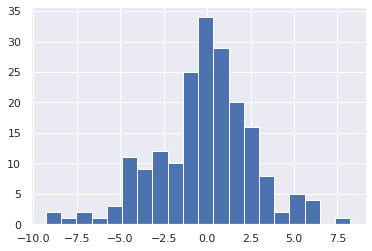

In [252]:
plt.hist(final_df['RMSE_no_cluster']-final_df['RMSE_with_cluster'], bins   =  20)

In [253]:
from scipy.stats import ttest_ind
ttest_ind(final_df['RMSE_no_cluster'],final_df['RMSE_with_cluster'])

Ttest_indResult(statistic=-0.1921882180450719, pvalue=0.8476953199683737)

In [254]:
final_df.shape

(195, 7)

In [255]:
final_df.mean()
final_df.median()

SE_no_cluster        63.829442
RMSE_topic_old       14.319046
RMSE_no_cluster       7.989333
SE_with_cluster      57.557419
RMSE_with_cluster     7.586661
dtype: float64

In [256]:
final_df.to_csv("KMeans_result2.csv", index = False)

<AxesSubplot:title={'center':'Compare RMSE for each new product, with/without clustering, and compare with old product clusters. '}, xlabel='StockCode'>

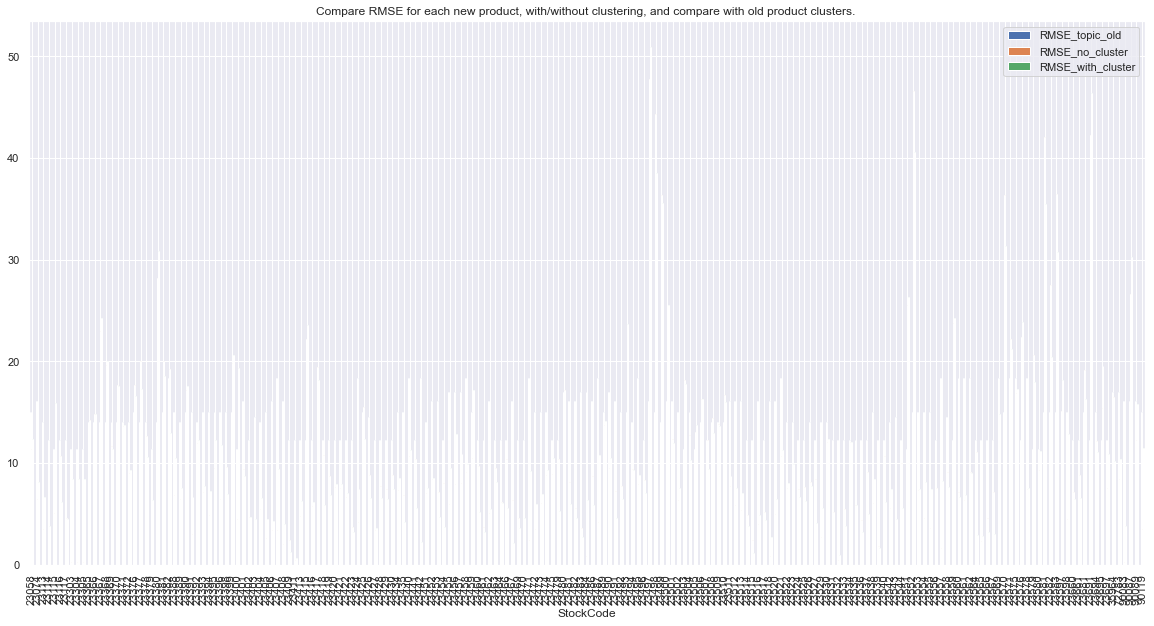

In [ ]:
final_df.plot('StockCode',['RMSE_topic_old','RMSE_no_cluster', 'RMSE_with_cluster'],kind = 'bar', figsize=(20,10), title = "Compare RMSE for each new product, with/without clustering, and compare with old product clusters. ")

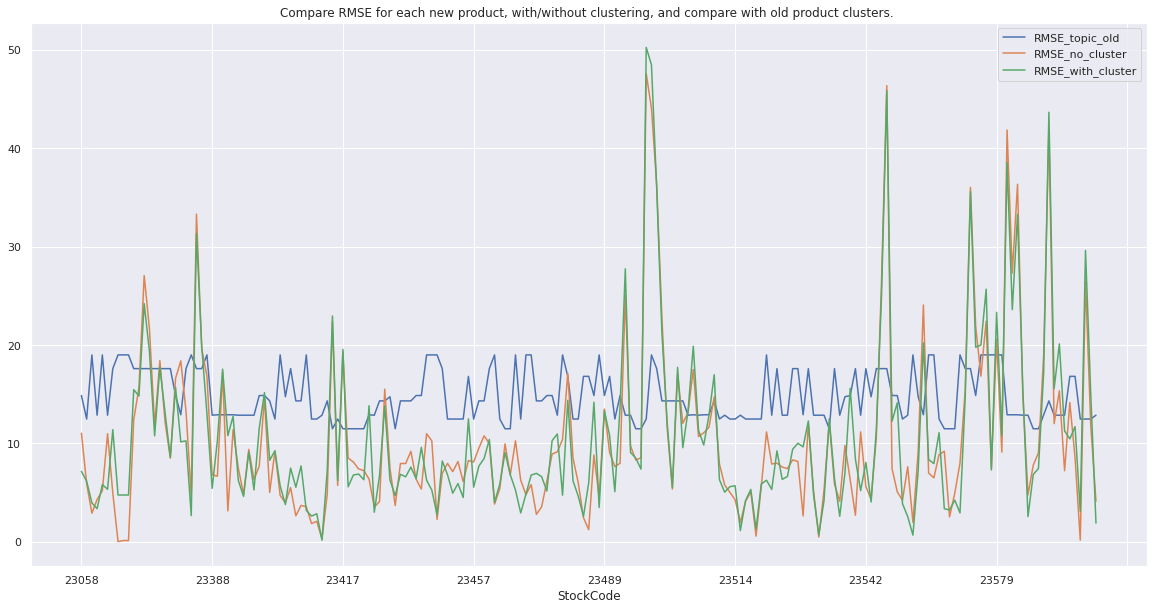

In [257]:
final_df.plot('StockCode',['RMSE_topic_old','RMSE_no_cluster', 'RMSE_with_cluster'],kind = 'line', figsize=(20,10), title = "Compare RMSE for each new product, with/without clustering, and compare with old product clusters. ")

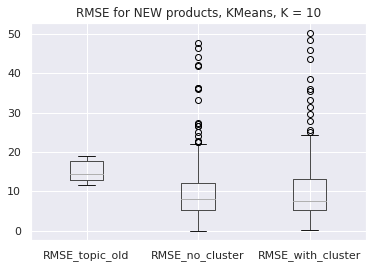

In [258]:
boxplot = final_df.boxplot(column=['RMSE_topic_old','RMSE_no_cluster', 'RMSE_with_cluster'])
plt.title('RMSE for NEW products, KMeans, K = 10')
plt.show()

In [259]:
final_df['RMSE_no_cluster'].mean()

10.456841012909948

In [260]:
final_df['RMSE_with_cluster'].mean()

10.627735592338171

#### Run LGBM on Merged data (new + old products), for each topic clusters: 

In [301]:
New_data = New_data1.drop(['Roberta','UnitPrice','Sales'], axis = 1)
New_data

,Date,StockCode,Year,Month,Week,Day,Weekday,is_weekend,Quantity,Description,Topic
120864,2011-09-01,23376,2011,9,35,1,3,0,48,pack of 12 vintage christmas tissue,0
120865,2011-09-01,23378,2011,9,35,1,3,0,48,pack of 12 50's christmas tissues,9
120878,2011-09-01,23551,2011,9,35,1,3,0,12,pack of 12 paisley park tissues,9
122173,2011-09-04,23377,2011,9,35,4,6,1,12,pack of 12 dolly girl tissues,1
122174,2011-09-04,23393,2011,9,35,4,6,1,10,home sweet home cushion cover,2
...,...,...,...,...,...,...,...,...,...,...,...
196160,2011-12-09,23570,2011,12,49,9,4,0,24,traditional pick up sticks game,9
196161,2011-12-09,23571,2011,12,49,9,4,0,12,traditional naughts & crosses,0
196162,2011-12-09,23581,2011,12,49,9,4,0,50,jumbo bag paisley park,1
196163,2011-12-09,23598,2011,12,49,9,4,0,6,paper bunting vintage party,2


In [302]:
# change Topic type to category:
New_data["Topic"] = New_data["Topic"].astype('category')

In [303]:
D = {}
for i in set(New_data["Topic"]):
    topics_new_df["New_data_D{0}".format(i)] = topics_new_df["New_data_D{0}".format(i)].drop(['Roberta','UnitPrice','Sales'], axis = 1)
    D["Merged_D{0}".format(i)] = pd.concat([topics_df["data_df_D{0}".format(i)],topics_new_df["New_data_D{0}".format(i)]])


In [304]:
Shape = {}
for i in D.keys():
    Shape.update({i: D[i].shape[0]})
     
print(Shape)    

{'Merged_D1': 24782, 'Merged_D3': 14282, 'Merged_D6': 11043, 'Merged_D0': 19547, 'Merged_D8': 14866, 'Merged_D9': 16438, 'Merged_D7': 8863, 'Merged_D4': 27662, 'Merged_D5': 23421, 'Merged_D2': 27717}


In [305]:
#number of records in each cluster:
records = pd.DataFrame.from_dict(Shape , orient='index' , columns=['records'])
records = records.reset_index()
records

,index,records
0,Merged_D1,24782
1,Merged_D3,14282
2,Merged_D6,11043
3,Merged_D0,19547
4,Merged_D8,14866
5,Merged_D9,16438
6,Merged_D7,8863
7,Merged_D4,27662
8,Merged_D5,23421
9,Merged_D2,27717


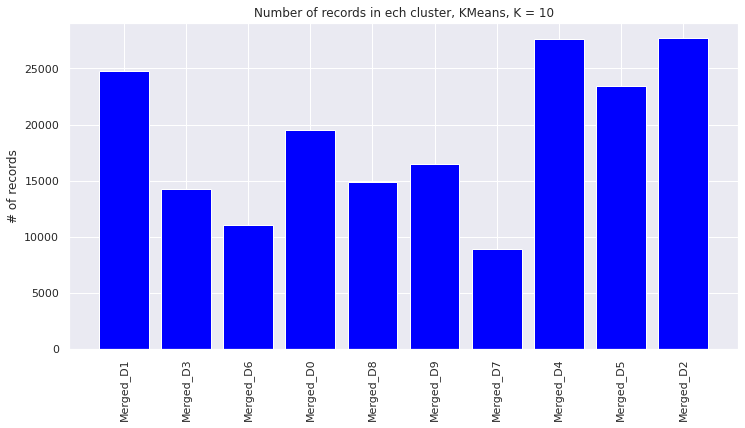

In [306]:
plt.figure(figsize=(12,6)) 
plt.bar(records['index'], records['records'] ,color="blue")
#records.plot(x='index', y='records', kind="bar")

plt.ylabel("# of records")
plt.title("Number of records in ech cluster, KMeans, K = 10");
plt.xticks(rotation=90)
plt.show()

In [307]:
x_tr_merg_df = {}
for i in D.keys():
    x_tr_merg_df[i] =  D[i][(D[i]['Date'] <= '2011-11-01')].drop(['Date','Description','Topic','Quantity'],axis = 1)
    x_tr_merg_df[i]["StockCode"] =  x_tr_merg_df[i]["StockCode"].astype('category')

In [308]:
y_tr_merg_df = {}
for i in D.keys():
    y_tr_merg_df[i] = D[i][(D[i]['Date'] <= '2011-11-01')]['Quantity']

In [309]:
x_val_merg_df = {}
for i in D.keys():
    x_val_merg_df[i] =  D[i][(D[i]['Date'] > '2011-11-01') & (D[i]['Date'] <= '2011-12-01')].drop(['Date','Description','Topic','Quantity'],axis = 1)
    x_val_merg_df[i]["StockCode"] =  x_val_merg_df[i]["StockCode"].astype('category')

In [310]:
y_val_merg_df = {}
for i in D.keys():
    y_val_merg_df[i] =  D[i][(D[i]['Date'] > '2011-11-01') & (D[i]['Date'] <= '2011-12-01')]['Quantity']

In [311]:
x_te_merg_df = {}
for i in D.keys():
    x_te_merg_df[i] =  D[i][(D[i]['Date']> '2011-12-01')].drop(['Date','Description','Topic','Quantity'],axis = 1)
    x_te_merg_df[i]["StockCode"] = x_te_merg_df[i]["StockCode"].astype('category')

In [312]:
y_te_merg_df = {}
for i in D.keys():
    y_te_merg_df[i] = D[i][(D[i]['Date'] > '2011-12-01')]['Quantity']

In [313]:
import optuna
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
model_merg_df = {}
pred_merg_df = {}
rmse_merg_df = {}
rmseVal_merg_df = {}
global_y_merg_df = []
global_pred_merg_df = []

for i in D.keys():
    #optimization:
    params = {}
    def objective(trial):


        param = {
            'metric': 'rmse', 
            'random_state': 48, ###########
            'n_estimators': trial.suggest_int('n_estimators', 100, 200, 500),
            'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
            'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
            'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
            'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
            'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
            # 'max_depth': trial.suggest_categorical('max_depth', [10,20,100]),
            'num_leaves' : trial.suggest_int('num_leaves', 30, 200, 1000),  ###############
            'min_child_samples': trial.suggest_int('min_child_samples', 10, 300),
            'cat_smooth' : trial.suggest_int('min_data_per_groups', 1, 100)
        }


        model_merg_df[i] = LGBMRegressor(**param)
        model_merg_df[i].fit(x_tr_merg_df[i],y_tr_merg_df[i],
                                        eval_set=[(x_val_merg_df[i],y_val_merg_df[i])],early_stopping_rounds=100,verbose=False)
        pred_merg_df[i] = model_merg_df[i].predict(x_te_merg_df[i])
        rmse_merg_df[i] = mean_squared_error(y_te_merg_df[i], model_merg_df[i].predict(x_te_merg_df[i]), squared=False)

        return rmse_merg_df[i]
    
    
    
    # the objective of our fuction is to minimize the RMSE that's why direction='minimize':
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=50)
    print('Number of finished trials:', len(study.trials))
    print('Best trial:', study.best_trial.params)
    params=study.best_params   


    model_merg_df[i] = LGBMRegressor(**params)
    model_merg_df[i].fit(x_tr_merg_df[i],y_tr_merg_df[i], eval_set=[(x_val_merg_df[i],y_val_merg_df[i])],early_stopping_rounds=100,verbose=False)
    pred_merg_df[i] = model_merg_df[i].predict(x_te_merg_df[i])
    rmse_merg_df[i] = mean_squared_error(y_te_merg_df[i], model_merg_df[i].predict(x_te_merg_df[i]), squared=False)
    rmseVal_merg_df[i] = mean_squared_error(y_val_merg_df[i],model_merg_df[i].predict(x_val_merg_df[i]), squared=False)
    global_y_merg_df.append(list(y_te_merg_df[i]))
    global_pred_merg_df.append(list(pred_merg_df[i]))



[I 2022-03-22 03:33:47,932] A new study created in memory with name: no-name-250fc150-6a3f-47c6-8c81-fa43c003ca46
[I 2022-03-22 03:33:48,225] Trial 0 finished with value: 15.185160138605069 and parameters: {'n_estimators': 100, 'reg_alpha': 0.002931852714834192, 'reg_lambda': 0.08428440430451928, 'colsample_bytree': 0.6, 'subsample': 0.4, 'learning_rate': 0.008, 'num_leaves': 30, 'min_child_samples': 64, 'min_data_per_groups': 12}. Best is trial 0 with value: 15.185160138605069.
[I 2022-03-22 03:33:48,456] Trial 1 finished with value: 14.833963077356008 and parameters: {'n_estimators': 100, 'reg_alpha': 0.5653983492317879, 'reg_lambda': 5.998109074197982, 'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.02, 'num_leaves': 30, 'min_child_samples': 213, 'min_data_per_groups': 25}. Best is trial 1 with value: 14.833963077356008.
[I 2022-03-22 03:33:48,669] Trial 2 finished with value: 15.819740953707552 and parameters: {'n_estimators': 100, 'reg_alpha': 0.0026469389738032396, 

Number of finished trials: 50
Best trial: {'n_estimators': 100, 'reg_alpha': 2.8373356902222198, 'reg_lambda': 1.300258122813458, 'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.017, 'num_leaves': 30, 'min_child_samples': 183, 'min_data_per_groups': 1}


[I 2022-03-22 03:34:03,192] A new study created in memory with name: no-name-a4c3fca5-1fa5-46be-a2b5-263d255303a6
[I 2022-03-22 03:34:03,340] Trial 0 finished with value: 15.233262497776922 and parameters: {'n_estimators': 100, 'reg_alpha': 0.01925347409516568, 'reg_lambda': 0.023182709868053878, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.008, 'num_leaves': 30, 'min_child_samples': 110, 'min_data_per_groups': 6}. Best is trial 0 with value: 15.233262497776922.
[I 2022-03-22 03:34:03,526] Trial 1 finished with value: 15.438001377273936 and parameters: {'n_estimators': 100, 'reg_alpha': 0.251101301422107, 'reg_lambda': 0.0018440689717821213, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.014, 'num_leaves': 30, 'min_child_samples': 212, 'min_data_per_groups': 97}. Best is trial 0 with value: 15.233262497776922.
[I 2022-03-22 03:34:03,723] Trial 2 finished with value: 14.837455822579708 and parameters: {'n_estimators': 100, 'reg_alpha': 4.70241012189663, '

Number of finished trials: 50
Best trial: {'n_estimators': 100, 'reg_alpha': 0.050015983906401065, 'reg_lambda': 0.013410978186053583, 'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.02, 'num_leaves': 30, 'min_child_samples': 70, 'min_data_per_groups': 8}


[I 2022-03-22 03:34:13,442] A new study created in memory with name: no-name-37bc8647-624e-4ecd-bbcb-df3386fb82c6
[I 2022-03-22 03:34:13,610] Trial 0 finished with value: 17.57754663411357 and parameters: {'n_estimators': 100, 'reg_alpha': 0.19592722263153672, 'reg_lambda': 3.122174443982478, 'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.01, 'num_leaves': 30, 'min_child_samples': 216, 'min_data_per_groups': 100}. Best is trial 0 with value: 17.57754663411357.
[I 2022-03-22 03:34:13,733] Trial 1 finished with value: 18.24463837433077 and parameters: {'n_estimators': 100, 'reg_alpha': 0.23210778311716856, 'reg_lambda': 0.0035294982901552196, 'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.006, 'num_leaves': 30, 'min_child_samples': 29, 'min_data_per_groups': 54}. Best is trial 0 with value: 17.57754663411357.
[I 2022-03-22 03:34:13,877] Trial 2 finished with value: 17.54631890865372 and parameters: {'n_estimators': 100, 'reg_alpha': 0.8620993991404015, 'reg_

Number of finished trials: 50
Best trial: {'n_estimators': 100, 'reg_alpha': 0.012313076695550283, 'reg_lambda': 4.925273492950396, 'colsample_bytree': 1.0, 'subsample': 0.4, 'learning_rate': 0.02, 'num_leaves': 30, 'min_child_samples': 189, 'min_data_per_groups': 26}


[I 2022-03-22 03:34:27,493] A new study created in memory with name: no-name-929d85d0-c434-47e3-94c0-1a0cb8075749
[I 2022-03-22 03:34:27,732] Trial 0 finished with value: 16.139733212929134 and parameters: {'n_estimators': 100, 'reg_alpha': 0.002364908263720107, 'reg_lambda': 0.27767296225371235, 'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.008, 'num_leaves': 30, 'min_child_samples': 264, 'min_data_per_groups': 92}. Best is trial 0 with value: 16.139733212929134.
[I 2022-03-22 03:34:27,952] Trial 1 finished with value: 16.117213796647523 and parameters: {'n_estimators': 100, 'reg_alpha': 0.07118164378259306, 'reg_lambda': 6.169650661897916, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.017, 'num_leaves': 30, 'min_child_samples': 232, 'min_data_per_groups': 93}. Best is trial 1 with value: 16.117213796647523.
[I 2022-03-22 03:34:28,160] Trial 2 finished with value: 16.124653139516685 and parameters: {'n_estimators': 100, 'reg_alpha': 0.002275665637327812

Number of finished trials: 50
Best trial: {'n_estimators': 100, 'reg_alpha': 0.006354228053439627, 'reg_lambda': 0.7334311104761385, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.017, 'num_leaves': 30, 'min_child_samples': 218, 'min_data_per_groups': 7}


[I 2022-03-22 03:34:40,504] A new study created in memory with name: no-name-208a14b7-8b72-4449-b900-4a4427757640
[I 2022-03-22 03:34:40,724] Trial 0 finished with value: 13.227374821754498 and parameters: {'n_estimators': 100, 'reg_alpha': 0.007329193860530059, 'reg_lambda': 8.083768678834756, 'colsample_bytree': 0.8, 'subsample': 0.4, 'learning_rate': 0.02, 'num_leaves': 30, 'min_child_samples': 147, 'min_data_per_groups': 18}. Best is trial 0 with value: 13.227374821754498.
[I 2022-03-22 03:34:40,924] Trial 1 finished with value: 13.794587600010281 and parameters: {'n_estimators': 100, 'reg_alpha': 4.009628524673848, 'reg_lambda': 0.1442399309920722, 'colsample_bytree': 0.8, 'subsample': 0.4, 'learning_rate': 0.02, 'num_leaves': 30, 'min_child_samples': 204, 'min_data_per_groups': 90}. Best is trial 0 with value: 13.227374821754498.
[I 2022-03-22 03:34:41,148] Trial 2 finished with value: 14.025398332585826 and parameters: {'n_estimators': 100, 'reg_alpha': 0.003155357365478752, 're

Number of finished trials: 50
Best trial: {'n_estimators': 100, 'reg_alpha': 0.007038530761198285, 'reg_lambda': 5.796076556806484, 'colsample_bytree': 0.9, 'subsample': 0.4, 'learning_rate': 0.02, 'num_leaves': 30, 'min_child_samples': 261, 'min_data_per_groups': 1}


[I 2022-03-22 03:34:51,238] A new study created in memory with name: no-name-695c9c1f-1620-48a1-8e0c-9762a4f8846b
[I 2022-03-22 03:34:51,469] Trial 0 finished with value: 18.69575814051476 and parameters: {'n_estimators': 100, 'reg_alpha': 0.02727703596324493, 'reg_lambda': 0.004613300003699679, 'colsample_bytree': 0.9, 'subsample': 0.8, 'learning_rate': 0.01, 'num_leaves': 30, 'min_child_samples': 234, 'min_data_per_groups': 52}. Best is trial 0 with value: 18.69575814051476.
[I 2022-03-22 03:34:51,676] Trial 1 finished with value: 19.046273868105825 and parameters: {'n_estimators': 100, 'reg_alpha': 0.2272763515613256, 'reg_lambda': 0.0018094216312225869, 'colsample_bytree': 0.8, 'subsample': 0.4, 'learning_rate': 0.02, 'num_leaves': 30, 'min_child_samples': 45, 'min_data_per_groups': 89}. Best is trial 0 with value: 18.69575814051476.
[I 2022-03-22 03:34:51,913] Trial 2 finished with value: 18.815314466941825 and parameters: {'n_estimators': 100, 'reg_alpha': 0.2829172511684776, 're

Number of finished trials: 50
Best trial: {'n_estimators': 100, 'reg_alpha': 2.7154846672635973, 'reg_lambda': 0.001030273528956384, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.008, 'num_leaves': 30, 'min_child_samples': 205, 'min_data_per_groups': 1}


[I 2022-03-22 03:35:02,206] A new study created in memory with name: no-name-e304ff44-d6f1-4ab4-9328-8af627f94144
[I 2022-03-22 03:35:02,317] Trial 0 finished with value: 14.945361231891393 and parameters: {'n_estimators': 100, 'reg_alpha': 3.2323660780869274, 'reg_lambda': 0.0034148969448802094, 'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.017, 'num_leaves': 30, 'min_child_samples': 129, 'min_data_per_groups': 79}. Best is trial 0 with value: 14.945361231891393.
[I 2022-03-22 03:35:02,419] Trial 1 finished with value: 14.91539010746784 and parameters: {'n_estimators': 100, 'reg_alpha': 0.030363120054100416, 'reg_lambda': 1.1900591371278464, 'colsample_bytree': 0.3, 'subsample': 0.6, 'learning_rate': 0.017, 'num_leaves': 30, 'min_child_samples': 235, 'min_data_per_groups': 12}. Best is trial 1 with value: 14.91539010746784.
[I 2022-03-22 03:35:02,564] Trial 2 finished with value: 14.501271119940984 and parameters: {'n_estimators': 100, 'reg_alpha': 4.431796144685122, '

Number of finished trials: 50
Best trial: {'n_estimators': 100, 'reg_alpha': 0.07689331591645737, 'reg_lambda': 0.13192425983242212, 'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.02, 'num_leaves': 30, 'min_child_samples': 118, 'min_data_per_groups': 54}


[I 2022-03-22 03:35:10,394] Trial 0 finished with value: 12.665172021081647 and parameters: {'n_estimators': 100, 'reg_alpha': 0.005316668996062367, 'reg_lambda': 0.060377074965272844, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.008, 'num_leaves': 30, 'min_child_samples': 120, 'min_data_per_groups': 18}. Best is trial 0 with value: 12.665172021081647.
[I 2022-03-22 03:35:10,713] Trial 1 finished with value: 12.213663855699307 and parameters: {'n_estimators': 100, 'reg_alpha': 0.25380831307295315, 'reg_lambda': 1.6063040177105903, 'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.014, 'num_leaves': 30, 'min_child_samples': 90, 'min_data_per_groups': 81}. Best is trial 1 with value: 12.213663855699307.
[I 2022-03-22 03:35:11,032] Trial 2 finished with value: 12.208232832942455 and parameters: {'n_estimators': 100, 'reg_alpha': 0.005777933497064748, 'reg_lambda': 0.07350013164213966, 'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.02, 'num_leave

Number of finished trials: 50
Best trial: {'n_estimators': 100, 'reg_alpha': 0.01368497456365527, 'reg_lambda': 0.006081658068893551, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.02, 'num_leaves': 30, 'min_child_samples': 257, 'min_data_per_groups': 29}


[I 2022-03-22 03:35:25,731] A new study created in memory with name: no-name-5201bb49-c46b-4634-ab4d-dd94d21d800d
[I 2022-03-22 03:35:25,912] Trial 0 finished with value: 19.33576586985169 and parameters: {'n_estimators': 100, 'reg_alpha': 1.7852889368122282, 'reg_lambda': 0.5231162264150822, 'colsample_bytree': 0.3, 'subsample': 0.8, 'learning_rate': 0.006, 'num_leaves': 30, 'min_child_samples': 27, 'min_data_per_groups': 22}. Best is trial 0 with value: 19.33576586985169.
[I 2022-03-22 03:35:26,103] Trial 1 finished with value: 19.287631244457632 and parameters: {'n_estimators': 100, 'reg_alpha': 0.1134714352244595, 'reg_lambda': 0.0016175796999660054, 'colsample_bytree': 0.3, 'subsample': 0.4, 'learning_rate': 0.008, 'num_leaves': 30, 'min_child_samples': 163, 'min_data_per_groups': 44}. Best is trial 1 with value: 19.287631244457632.
[I 2022-03-22 03:35:26,320] Trial 2 finished with value: 19.21364839070647 and parameters: {'n_estimators': 100, 'reg_alpha': 3.1974944357865036, 'reg

Number of finished trials: 50
Best trial: {'n_estimators': 100, 'reg_alpha': 0.10971558163149583, 'reg_lambda': 3.8497307944333308, 'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.014, 'num_leaves': 30, 'min_child_samples': 209, 'min_data_per_groups': 60}


[I 2022-03-22 03:35:39,428] A new study created in memory with name: no-name-89f79cdd-6720-4aa0-8d9e-8ab3426d31d1
[I 2022-03-22 03:35:39,697] Trial 0 finished with value: 14.00599036212369 and parameters: {'n_estimators': 100, 'reg_alpha': 0.0010737913753191169, 'reg_lambda': 2.3427715493099326, 'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.008, 'num_leaves': 30, 'min_child_samples': 203, 'min_data_per_groups': 91}. Best is trial 0 with value: 14.00599036212369.
[I 2022-03-22 03:35:39,928] Trial 1 finished with value: 14.0767211315893 and parameters: {'n_estimators': 100, 'reg_alpha': 0.09786518707259709, 'reg_lambda': 0.011334816751040987, 'colsample_bytree': 0.4, 'subsample': 0.7, 'learning_rate': 0.01, 'num_leaves': 30, 'min_child_samples': 200, 'min_data_per_groups': 1}. Best is trial 0 with value: 14.00599036212369.
[I 2022-03-22 03:35:40,224] Trial 2 finished with value: 12.953778799898762 and parameters: {'n_estimators': 100, 'reg_alpha': 0.07265471454262869, 're

Number of finished trials: 50
Best trial: {'n_estimators': 100, 'reg_alpha': 0.38981277098276723, 'reg_lambda': 0.013402350242087269, 'colsample_bytree': 1.0, 'subsample': 0.4, 'learning_rate': 0.02, 'num_leaves': 30, 'min_child_samples': 160, 'min_data_per_groups': 15}


In [341]:
rmse_merg_df.values

rmse_merg_df_sqrt = []
for i in rmse_merg_df.keys():
  rmse_merg_df_sqrt.append(math.sqrt(rmse_merg_df[i]))

rmse_merg_df_sqrt

[3.800846651855227,
 3.810654037284646,
 4.07991510519015,
 3.8183681274370507,
 3.6281538482238496,
 4.285554101182507,
 3.78556044776862,
 3.4058152244612807,
 4.340692527167891,
 3.532690430036468]

In [343]:
rmse_merg = pd.Series(rmse_merg_df_sqrt)
rmse_merg.head()

0    3.800847
1    3.810654
2    4.079915
3    3.818368
4    3.628154
dtype: float64

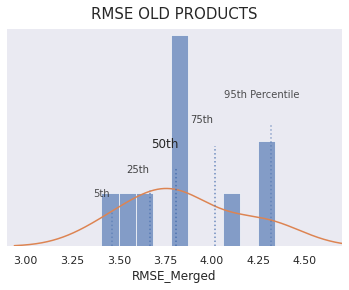

In [345]:
fig, ax = plt.subplots(figsize = (6,4))
    # Plot histogram
rmse_merg.plot(kind = "hist", density = True, alpha = 0.65, bins = 10) # change density to true, because KDE uses density
    # Plot KDE
rmse_merg.plot(kind = "kde")

    # Quantile lines
quant_5, quant_25, quant_50, quant_75, quant_95 = rmse_merg.quantile(0.05), rmse_merg.quantile(0.25), rmse_merg.quantile(0.5), rmse_merg.quantile(0.75), rmse_merg.quantile(0.95)
    # [quantile, opacity, length]
quants = [[quant_5, 0.6, 0.16], [quant_25, 0.8, 0.26], [quant_50, 1, 0.36],  [quant_75, 0.8, 0.46], [quant_95, 0.6, 0.56]]
for i in quants:
    ax.axvline(i[0], alpha = i[1], ymax = i[2], linestyle = ":")


# X
ax.set_xlabel("RMSE_Merged")   
x_start, x_end = 2.9, 4.7
ax.set_xlim(x_start, x_end)

# Y
ax.set_ylim(0, 4.4)
ax.set_yticklabels([])
ax.set_ylabel("")

# Annotations
ax.text(quant_5-.1, 1, "5th", size = 10, alpha = 0.8)
ax.text(quant_25-.13, 1.5, "25th", size = 10, alpha = 0.85)
ax.text(quant_50-.13, 2, "50th", size = 12, alpha = 1)
ax.text(quant_75-.13, 2.5, "75th", size = 10, alpha = 0.85)
ax.text(quant_95-.25, 3, "95th Percentile", size = 10, alpha =.8)

# Overall
ax.grid(False)
ax.set_title("RMSE OLD PRODUCTS", size = 15, pad = 10)

    # Remove ticks and spines
ax.tick_params(left = False, bottom = False)
for ax, spine in ax.spines.items():
    spine.set_visible(False)
    
plt.show()

In [ ]:
#np.mean(list(rmse_merg_df.values()))

In [314]:
global_pred_merg = []
for i in (global_pred_merg_df):
    for j in i:
        global_pred_merg.append(j)
    
global_y_merg = []
for i in (global_y_merg_df):
    for j in i:
        global_y_merg.append(j)

#### finding the RMSE without MEAN:

In [315]:
mean_squared_error(global_y_merg, global_pred_merg, squared=False)

14.921500496263555

#### Run one LGBM on whole Merged data:

In [316]:
Merged = [data_df,New_data]
Merged = pd.concat(Merged)
Merged

,Date,StockCode,Year,Month,Week,Day,Weekday,is_weekend,Quantity,Description,Topic
0,2010-12-01,10002,2010,12,48,1,2,0,60,inflatable political globe,6
1,2010-12-01,10125,2010,12,48,1,2,0,2,mini funky design tapes,2
2,2010-12-01,10133,2010,12,48,1,2,0,5,colouring pencils brown tube,9
3,2010-12-01,16014,2010,12,48,1,2,0,10,small chinese style scissor,8
4,2010-12-01,16016,2010,12,48,1,2,0,10,large chinese style scissor,8
...,...,...,...,...,...,...,...,...,...,...,...
196160,2011-12-09,23570,2011,12,49,9,4,0,24,traditional pick up sticks game,9
196161,2011-12-09,23571,2011,12,49,9,4,0,12,traditional naughts & crosses,0
196162,2011-12-09,23581,2011,12,49,9,4,0,50,jumbo bag paisley park,1
196163,2011-12-09,23598,2011,12,49,9,4,0,6,paper bunting vintage party,2


In [317]:
# change StockCode type to category:
Merged["StockCode"] = Merged["StockCode"].astype('category')

In [318]:
x_tr_merged_all_df = Merged[(Merged['Date'] <= '2011-11-01')].drop(['Date','Description','Quantity','Topic'],axis = 1)

In [319]:
y_tr_merged_all_df = Merged[(Merged['Date'] <= '2011-11-01')]['Quantity']

In [320]:
x_val_merged_all_df = Merged[(Merged['Date']>'2011-11-01') & (Merged['Date']<='2011-12-01')].drop(['Date','Description','Quantity','Topic'],axis = 1)

In [321]:
y_val_merged_all_df = Merged[(Merged['Date']>'2011-11-01') & (Merged['Date']<='2011-12-01')]['Quantity']

In [322]:
x_te_merged_all_df = Merged[(Merged['Date']>'2011-12-01')].drop(['Date','Description','Quantity','Topic'],axis = 1)

In [323]:
y_te_merged_all_df = Merged[(Merged['Date']>'2011-12-01')]['Quantity']

In [324]:
import optuna
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
#optimization:
def objective(trial):
    
    
    param = {
            'metric': 'rmse', 
            'random_state': 48,
            'n_estimators': trial.suggest_int('n_estimators', 100, 200, 500),
            'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
            'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
            'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
            'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
            'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
            # 'max_depth': trial.suggest_categorical('max_depth', [10,20,100]),
            'num_leaves' : trial.suggest_int('num_leaves', 30, 200, 1000),  
            'min_child_samples': trial.suggest_int('min_child_samples', 10, 300),
            'cat_smooth' : trial.suggest_int('min_data_per_groups', 1, 100)
    }
        
        
    model_merged_all_df = LGBMRegressor(**param)
        
    model_merged_all_df.fit(x_tr_merged_all_df,y_tr_merged_all_df,
                                        eval_set=[(x_val_merged_all_df,y_val_merged_all_df)],early_stopping_rounds=100,verbose=False)
    pred_merged_all_df = model_merged_all_df.predict(x_te_merged_all_df)
    rmse_merged_all_df = mean_squared_error(y_te_merged_all_df, model_merged_all_df.predict(x_te_merged_all_df), squared=False)
   

    return rmse_merged_all_df

In [325]:
# the objective of our fuction is to minimize the RMSE that's why direction='minimize':
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
params=study.best_params   


model_merged_all_df= LGBMRegressor(**params)
model_merged_all_df.fit(x_tr_merged_all_df,y_tr_merged_all_df, eval_set=[(x_val_merged_all_df,y_val_merged_all_df)],early_stopping_rounds=100,verbose=False)
pred_merged_all_df = model_merged_all_df.predict(x_te_merged_all_df)
rmse_merged_all_df = mean_squared_error(y_te_merged_all_df, model_merged_all_df.predict(x_te_merged_all_df), squared=False)
rmseVal_merged_all_df = mean_squared_error(y_val_merged_all_df, model_merged_all_df.predict(x_val_merged_all_df), squared=False)



[I 2022-03-22 03:36:14,652] A new study created in memory with name: no-name-55912ce5-c3d7-401e-a301-9802c7e4a4c6
[I 2022-03-22 03:36:16,863] Trial 0 finished with value: 15.270732659786747 and parameters: {'n_estimators': 100, 'reg_alpha': 0.40693037267691634, 'reg_lambda': 0.05449695992044778, 'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.017, 'num_leaves': 30, 'min_child_samples': 78, 'min_data_per_groups': 33}. Best is trial 0 with value: 15.270732659786747.
[I 2022-03-22 03:36:18,822] Trial 1 finished with value: 15.83841477680193 and parameters: {'n_estimators': 100, 'reg_alpha': 0.004153615558277618, 'reg_lambda': 0.7145461363047654, 'colsample_bytree': 0.8, 'subsample': 0.7, 'learning_rate': 0.008, 'num_leaves': 30, 'min_child_samples': 244, 'min_data_per_groups': 87}. Best is trial 0 with value: 15.270732659786747.
[I 2022-03-22 03:36:20,931] Trial 2 finished with value: 15.858348671448704 and parameters: {'n_estimators': 100, 'reg_alpha': 0.008510439835707612,

Number of finished trials: 50
Best trial: {'n_estimators': 100, 'reg_alpha': 0.12495143751429036, 'reg_lambda': 0.034983411945142755, 'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.02, 'num_leaves': 30, 'min_child_samples': 282, 'min_data_per_groups': 6}


In [326]:
math.sqrt(rmse_merged_all_df)

3.8770796834590597

#### Run one LGBM on New_data, with Topics, without merging with Old data:

In [328]:
x_tr_topic_new_df = New_data[(New_data['Date'] <= '2011-11-01')].drop(['Date','Description','Quantity'],axis = 1)

In [329]:
y_tr_topic_new_df = New_data[(New_data['Date'] <= '2011-11-01')]['Quantity']

In [330]:
x_val_topic_new_df = New_data[(New_data['Date']>'2011-11-01') & (New_data['Date']<='2011-12-01')].drop(['Date','Description','Quantity'],axis = 1)

In [331]:
y_val_topic_new_df = New_data[(New_data['Date']>'2011-11-01') & (New_data['Date']<='2011-12-01')]['Quantity']

In [332]:
x_te_topic_new_df = New_data[(New_data['Date']>'2011-12-01')].drop(['Date','Description','Quantity'],axis = 1)

In [333]:
y_te_topic_new_df = New_data[(New_data['Date']>'2011-12-01')]['Quantity']

In [334]:
import optuna
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
#optimization:
def objective(trial):
    
    
    param = {
            'metric': 'rmse', 
            'random_state': 48,
            'n_estimators': trial.suggest_int('n_estimators', 100, 200, 500),
            'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
            'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
            'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
            'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
            'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
            # 'max_depth': trial.suggest_categorical('max_depth', [10,20,100]),
            'num_leaves' : trial.suggest_int('num_leaves', 30, 200, 1000),  
            'min_child_samples': trial.suggest_int('min_child_samples', 10, 300),
            'cat_smooth' : trial.suggest_int('min_data_per_groups', 1, 100)
    }
        
        
    model_topic_new_df = LGBMRegressor(**param)
        
    model_topic_new_df.fit(x_tr_topic_new_df,y_tr_topic_new_df,
                                        eval_set=[(x_val_topic_new_df,y_val_topic_new_df)],early_stopping_rounds=100,verbose=False)
    pred_topic_new_df = model_topic_new_df.predict(x_te_topic_new_df)
    rmse_topic_new_df = mean_squared_error(y_te_topic_new_df, model_topic_new_df.predict(x_te_topic_new_df), squared=False)

    return rmse_topic_new_df

In [335]:
# the objective of our fuction is to minimize the RMSE that's why direction='minimize':
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
params=study.best_params   


model_topic_new_df= LGBMRegressor(**params)
model_topic_new_df.fit(x_tr_topic_new_df,y_tr_topic_new_df, eval_set=[(x_val_topic_new_df,y_val_topic_new_df)],early_stopping_rounds=100,verbose=False)
pred_topic_new_df = model_topic_new_df.predict(x_te_topic_new_df)
rmse_topic_new_df = mean_squared_error(y_te_topic_new_df, model_topic_new_df.predict(x_te_topic_new_df), squared=False)
rmseVal_topic_new_df = mean_squared_error(y_val_topic_new_df, model_topic_new_df.predict(x_val_topic_new_df), squared=False)


[I 2022-03-22 03:43:05,331] A new study created in memory with name: no-name-154c8e7b-3931-44e2-9261-5ac9ec52221e
[I 2022-03-22 03:43:05,437] Trial 0 finished with value: 16.453377203714172 and parameters: {'n_estimators': 100, 'reg_alpha': 0.21066877659343194, 'reg_lambda': 6.971899778569673, 'colsample_bytree': 1.0, 'subsample': 0.8, 'learning_rate': 0.006, 'num_leaves': 30, 'min_child_samples': 226, 'min_data_per_groups': 80}. Best is trial 0 with value: 16.453377203714172.
[I 2022-03-22 03:43:05,512] Trial 1 finished with value: 16.561897651221773 and parameters: {'n_estimators': 100, 'reg_alpha': 0.041742894890080984, 'reg_lambda': 0.01750156159946827, 'colsample_bytree': 0.3, 'subsample': 0.8, 'learning_rate': 0.006, 'num_leaves': 30, 'min_child_samples': 272, 'min_data_per_groups': 68}. Best is trial 0 with value: 16.453377203714172.
[I 2022-03-22 03:43:05,596] Trial 2 finished with value: 16.500502430773725 and parameters: {'n_estimators': 100, 'reg_alpha': 1.0021931258808094, 

Number of finished trials: 50
Best trial: {'n_estimators': 100, 'reg_alpha': 0.03337001754125365, 'reg_lambda': 0.4974233284653934, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.02, 'num_leaves': 30, 'min_child_samples': 107, 'min_data_per_groups': 1}


In [336]:
math.sqrt(rmse_topic_new_df)

4.012161537566471